<a href="https://colab.research.google.com/github/Antony-6487/Credit_Card_Fraud_Detection_Predictor/blob/main/Credit_Card_Fraud_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
)

Importing warnings

In [2]:
import warnings

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use("ggplot")
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.float_format', '{:.4f}'.format)
warnings.filterwarnings("ignore")

# **1. Data Loading and EDA**

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip
df = pd.read_csv("creditcard.csv", dtype={"Time": "float64", "Amount": "float64"})
df = df.sort_values("Time").reset_index(drop=True)


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open creditcardfraud.zip, creditcardfraud.zip.zip or creditcardfraud.zip.ZIP.


In [4]:
print("Data loaded successfully!")
print(df.shape)
print(df.head())

Data loaded successfully!
(19898, 31)
    Time      V1      V2     V3      V4      V5      V6      V7     V8  \
0 0.0000 -1.3598 -0.0728 2.5363  1.3782 -0.3383  0.4624  0.2396 0.0987   
1 0.0000  1.1919  0.2662 0.1665  0.4482  0.0600 -0.0824 -0.0788 0.0851   
2 1.0000 -1.3584 -1.3402 1.7732  0.3798 -0.5032  1.8005  0.7915 0.2477   
3 1.0000 -0.9663 -0.1852 1.7930 -0.8633 -0.0103  1.2472  0.2376 0.3774   
4 2.0000 -0.4260  0.9605 1.1411 -0.1683  0.4210 -0.0297  0.4762 0.2603   

       V9  ...     V21     V22     V23     V24     V25     V26     V27  \
0  0.3638  ... -0.0183  0.2778 -0.1105  0.0669  0.1285 -0.1891  0.1336   
1 -0.2554  ... -0.2258 -0.6387  0.1013 -0.3398  0.1672  0.1259 -0.0090   
2 -1.5147  ...  0.2480  0.7717  0.9094 -0.6893 -0.3276 -0.1391 -0.0554   
3 -1.3870  ... -0.1083  0.0053 -0.1903 -1.1756  0.6474 -0.2219  0.0627   
4 -0.5687  ... -0.2083 -0.5598 -0.0264 -0.3714 -0.2328  0.1059  0.2538   

      V28   Amount  Class  
0 -0.0211 149.6200 0.0000  
1  0.0147   2.69

In [5]:
print("\nBasic Statistics:")
display(df.describe())


Basic Statistics:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,19898.0000,19898.0000,19898.0000,19898.0000,19898.0000,19898.0000,19898.0000,19898.0000,19898.0000,19898.0000,...,19897.0000,19897.0000,19897.0000,19897.0000,19897.0000,19897.0000,19897.0000,19897.0000,19897.0000,19897.0000
mean,15492.4164,-0.2443,0.2424,0.7458,0.2770,-0.1633,0.0929,-0.1453,0.0222,0.6364,...,-0.0479,-0.1465,-0.0381,0.0107,0.1229,0.0331,0.0145,0.0073,70.2711,0.0043
std,10512.0667,1.8900,1.5273,1.7677,1.4662,1.4308,1.3310,1.3383,1.3468,1.2788,...,0.8284,0.6376,0.5207,0.5912,0.4377,0.5303,0.3930,0.2444,205.3638,0.0652
min,0.0000,-30.5524,-40.9789,-31.1037,-5.1726,-32.0921,-23.4967,-26.5481,-41.4848,-7.1751,...,-20.2621,-8.5936,-26.7511,-2.7287,-7.4957,-1.3386,-8.5676,-3.5753,0.0000,0.0000
25%,4536.2500,-0.9596,-0.3290,0.3092,-0.6367,-0.7452,-0.6573,-0.5994,-0.1718,-0.2096,...,-0.2595,-0.5640,-0.1742,-0.3333,-0.1383,-0.3419,-0.0691,-0.0109,5.7500,0.0000
50%,14796.0000,-0.3025,0.2201,0.8987,0.2246,-0.1994,-0.1754,-0.0723,0.0238,0.6202,...,-0.1154,-0.1188,-0.0470,0.0612,0.1605,-0.0365,0.0039,0.0191,16.0000,0.0000
75%,26220.5000,1.1645,0.8701,1.5329,1.1421,0.3414,0.4867,0.4486,0.2800,1.4091,...,0.0495,0.2541,0.0737,0.3985,0.4007,0.3327,0.0963,0.0776,59.9800,0.0000
max,30633.0000,1.9605,16.7134,4.1017,11.9275,34.0993,21.3931,34.3032,20.0072,10.3929,...,22.6149,5.8058,13.8762,3.6955,5.5251,3.5173,8.2544,4.8608,7879.4200,1.0000


In [6]:
# Check for missing values
print("Missing Values:")
display(df.isnull().sum())



Missing Values:


,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [7]:

print("\nDataset Information:")
display(df.info())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19898 entries, 0 to 19897
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    19898 non-null  float64
 1   V1      19898 non-null  float64
 2   V2      19898 non-null  float64
 3   V3      19898 non-null  float64
 4   V4      19898 non-null  float64
 5   V5      19898 non-null  float64
 6   V6      19898 non-null  float64
 7   V7      19898 non-null  float64
 8   V8      19898 non-null  float64
 9   V9      19898 non-null  float64
 10  V10     19898 non-null  float64
 11  V11     19897 non-null  float64
 12  V12     19897 non-null  float64
 13  V13     19897 non-null  float64
 14  V14     19897 non-null  float64
 15  V15     19897 non-null  float64
 16  V16     19897 non-null  float64
 17  V17     19897 non-null  float64
 18  V18     19897 non-null  float64
 19  V19     19897 non-null  float64
 20  V20     19897 non-null  float64
 21  V21     19897

None

1.1 Handling the Data Imbalance

In [18]:
class_counts = df["Class"].value_counts()
print("Class Distribution:")
print(class_counts)
print(f"\nFraud Percentage: {100 * class_counts[1] / len(df):.4f}%")

Class Distribution:
Class
0.0000    19812
1.0000       85
Name: count, dtype: int64

Fraud Percentage: 0.4272%


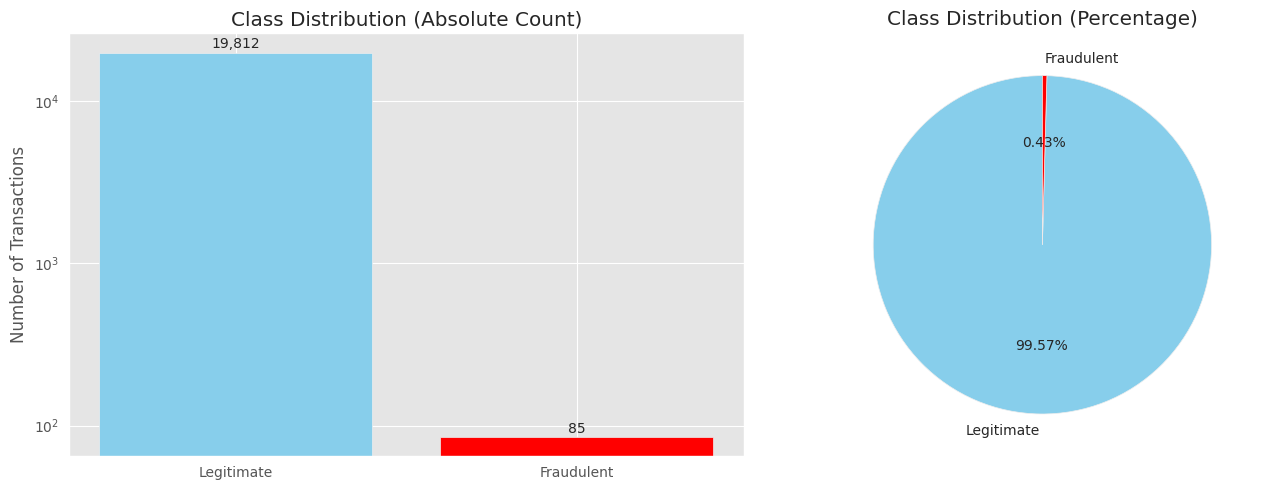

In [9]:
class_counts = df["Class"].value_counts()
# Visualize class imbalance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))#side by side plots
# Bar plot
bars = axes[0].bar(['Legitimate', 'Fraudulent'], class_counts.values, color=['skyblue', 'red'])
axes[0].set_ylabel('Number of Transactions')
axes[0].set_title('Class Distribution (Absolute Count)')
axes[0].set_yscale('log')  # Log scale to see both classes...since the fraudulent class is so small

# Add value labels on top of bars
axes[0].bar_label(bars, labels=[f'{v:,}' for v in class_counts.values],
                  label_type='edge', fontsize=10, padding=1)

# Pie chart
colors = ['skyblue', 'red']
axes[1].pie(class_counts.values, labels=['Legitimate', 'Fraudulent'],
            autopct='%1.2f%%', colors=colors, startangle=90)
axes[1].set_title('Class Distribution (Percentage)')

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

1.2 Feature Engineering

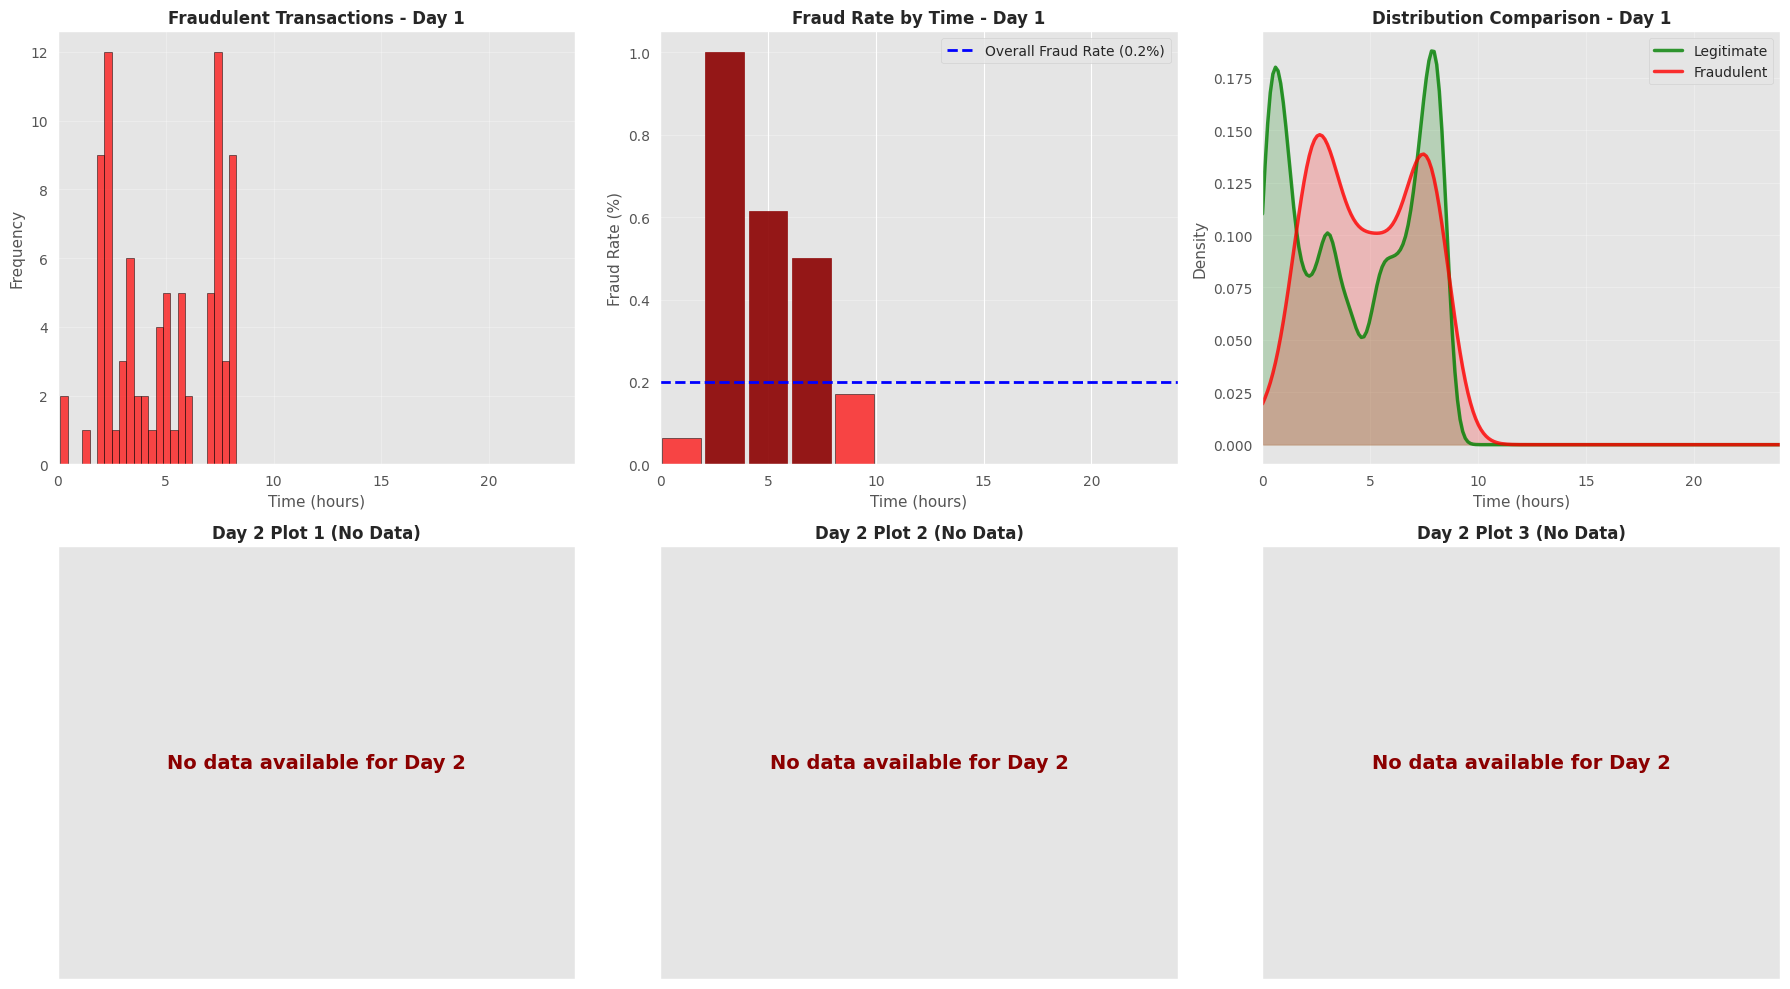

In [10]:

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

day1_mask = df["Time"] / 3600 < 24
day2_mask = df["Time"] / 3600 >= 24

day1_fraud = df[(df["Class"] == 1) & day1_mask]["Time"] / 3600
day2_fraud = (df[(df["Class"] == 1) & day2_mask]["Time"] / 3600) - 24

day1_legit = df[(df["Class"] == 0) & day1_mask]["Time"] / 3600
day2_legit = (df[(df["Class"] == 0) & day2_mask]["Time"] / 3600) - 24


# ============= DAY 1 (Top Row) =============

# Plot 1: Day 1 Fraudulent transaction volume
axes[0, 0].hist(day1_fraud, bins=24, alpha=0.7, color="red", edgecolor="black")
axes[0, 0].set_xlabel("Time (hours)", fontsize=11)
axes[0, 0].set_ylabel("Frequency", fontsize=11)
axes[0, 0].set_title("Fraudulent Transactions - Day 1", fontsize=12, fontweight="bold")
axes[0, 0].set_xlim(0, 24)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Day 1 Fraud rate by time
time_bins_day = np.linspace(0, 24, 13)  # 12 bins of 2 hours each
legit_counts_d1, _ = np.histogram(day1_legit, bins=time_bins_day)
fraud_counts_d1, _ = np.histogram(day1_fraud, bins=time_bins_day)
fraud_rate_d1 = fraud_counts_d1 / (legit_counts_d1 + fraud_counts_d1 + 1e-10) * 100
bin_centers_day = (time_bins_day[:-1] + time_bins_day[1:]) / 2

bars_d1 = axes[0, 1].bar(
    bin_centers_day, fraud_rate_d1, width=1.8, color="red", alpha=0.7, edgecolor="black"
)
axes[0, 1].axhline(
    y=0.2, color="blue", linestyle="--", linewidth=2, label="Overall Fraud Rate (0.2%)"
)

# Highlight high-risk periods
for i, rate in enumerate(fraud_rate_d1):
    if rate > 0.5:
        bars_d1[i].set_color("darkred")
        bars_d1[i].set_alpha(0.9)

axes[0, 1].set_xlabel("Time (hours)", fontsize=11)
axes[0, 1].set_ylabel("Fraud Rate (%)", fontsize=11)
axes[0, 1].set_title("Fraud Rate by Time - Day 1", fontsize=12, fontweight="bold")
axes[0, 1].set_xlim(0, 24)
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis="y")

# Plot 3: Day 1 KDE
from scipy import stats

legit_kde_d1 = stats.gaussian_kde(day1_legit)
fraud_kde_d1 = stats.gaussian_kde(day1_fraud)
time_range_day = np.linspace(0, 24, 200)

axes[0, 2].plot(
    time_range_day,
    legit_kde_d1(time_range_day),
    color="green",
    linewidth=2.5,
    label="Legitimate",
    alpha=0.8,
)
axes[0, 2].plot(
    time_range_day,
    fraud_kde_d1(time_range_day),
    color="red",
    linewidth=2.5,
    label="Fraudulent",
    alpha=0.8,
)
axes[0, 2].fill_between(
    time_range_day, legit_kde_d1(time_range_day), alpha=0.2, color="green"
)
axes[0, 2].fill_between(
    time_range_day, fraud_kde_d1(time_range_day), alpha=0.2, color="red"
)
axes[0, 2].set_xlabel("Time (hours)", fontsize=11)
axes[0, 2].set_ylabel("Density", fontsize=11)
axes[0, 2].set_title("Distribution Comparison - Day 1", fontsize=12, fontweight="bold")
axes[0, 2].set_xlim(0, 24)
axes[0, 2].legend(fontsize=10)
axes[0, 2].grid(True, alpha=0.3)

# ============= DAY 2 (Bottom Row) =============
if day2_mask.any(): # Check if there is any data for Day 2
    # Plot 4: Day 2 Fraudulent transaction volume
    axes[1, 0].hist(day2_fraud, bins=24, alpha=0.7, color="red", edgecolor="black")
    axes[1, 0].set_xlabel("Time (hours)", fontsize=11)
    axes[1, 0].set_ylabel("Frequency", fontsize=11)
    axes[1, 0].set_title("Fraudulent Transactions - Day 2", fontsize=12, fontweight="bold")
    axes[1, 0].set_xlim(0, 24)
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 5: Day 2 Fraud rate by time
    legit_counts_d2, _ = np.histogram(day2_legit, bins=time_bins_day)
    fraud_counts_d2, _ = np.histogram(day2_fraud, bins=time_bins_day)
    fraud_rate_d2 = fraud_counts_d2 / (legit_counts_d2 + fraud_counts_d2 + 1e-10) * 100

    bars_d2 = axes[1, 1].bar(
        bin_centers_day, fraud_rate_d2, width=1.8, color="red", alpha=0.7, edgecolor="black"
    )
    axes[1, 1].axhline(
        y=0.2, color="blue", linestyle="--", linewidth=2, label="Overall Fraud Rate (0.2%)"
    )

    # Highlight high-risk periods
    for i, rate in enumerate(fraud_rate_d2):
        if rate > 0.5:
            bars_d2[i].set_color("darkred")
            bars_d2[i].set_alpha(0.9)

    axes[1, 1].set_xlabel("Time (hours)", fontsize=11)
    axes[1, 1].set_ylabel("Fraud Rate (%)", fontsize=11)
    axes[1, 1].set_title("Fraud Rate by Time - Day 2", fontsize=12, fontweight="bold")
    axes[1, 1].set_xlim(0, 24)
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3, axis="y")

    # Plot 6: Day 2 KDE
    # Check explicitly for data count for KDE
    has_legit_data = len(day2_legit) > 1
    has_fraud_data = len(day2_fraud) > 1

    if has_legit_data:
        legit_kde_d2 = stats.gaussian_kde(day2_legit)
        axes[1, 2].plot(
            time_range_day, legit_kde_d2(time_range_day), color="green", linewidth=2.5, label="Legitimate", alpha=0.8
        )
        axes[1, 2].fill_between(time_range_day, legit_kde_d2(time_range_day), alpha=0.2, color="green")
    if has_fraud_data:
        fraud_kde_d2 = stats.gaussian_kde(day2_fraud)
        axes[1, 2].plot(
            time_range_day, fraud_kde_d2(time_range_day), color="red", linewidth=2.5, label="Fraudulent", alpha=0.8
        )
        axes[1, 2].fill_between(time_range_day, fraud_kde_d2(time_range_day), alpha=0.2, color="red")

    if not has_legit_data and not has_fraud_data:
        axes[1, 2].text(0.5, 0.5, "Not enough data for Day 2 KDE",
                        horizontalalignment='center', verticalalignment='center',
                        transform=axes[1, 2].transAxes, fontsize=10, color='gray')
    else:
        axes[1, 2].set_xlabel("Time (hours)", fontsize=11)
        axes[1, 2].set_ylabel("Density", fontsize=11)
        axes[1, 2].set_title("Distribution Comparison - Day 2", fontsize=12, fontweight="bold")
        axes[1, 2].set_xlim(0, 24)
        axes[1, 2].legend(fontsize=10)
        axes[1, 2].grid(True, alpha=0.3)

else:
    # Handle the case where no data exists for Day 2 at all
    for idx in range(3):
        axes[1, idx].set_xticks([])
        axes[1, idx].set_yticks([])
        axes[1, idx].text(0.5, 0.5, "No data available for Day 2",
                          horizontalalignment='center', verticalalignment='center',
                          transform=axes[1, idx].transAxes,
                          fontsize=14, color='darkred', fontweight='bold')
        axes[1, idx].set_title(f"Day 2 Plot {idx+1} (No Data)", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig("temporal_analysis_by_day.png", dpi=300, bbox_inches="tight")
plt.show()

Volume of Fraudulent Transactions

The histograms show the absolute frequency of fraudulent transactions over 12 hours  for which the following patterns are identified:
A pronounced peak is observed around 10-12 hours (midday), with approximately 45 fraudulent transactions concentrated in that period. Additionally, moderate but constant activity is recorded at other times of the day, with frequencies between 5-20 transactions


From this graph, it can be deduced that fraudsters operate during certain periods of the day, especially near midday (moments of high transactional traffic) and early morning hours(moments of less supervision).

### Fraud Rate by Period (Central Column)

These graphs represent the fraud percentage relative to the total volume of transactions.  
The fraud rate is calculated using the following formula:

\[
\text{Fraud Rate} = \frac{\text{Number of Fraudulent Transactions}}{\text{Total Number of Transactions}} \times 100
\]

The **blue dotted line** indicates the average fraud rate of the dataset (**0.2%**), serving as a reference to identify high-risk periods.

---

### **Day 1 Analysis**

During the early morning hours (**1–6 hours**), there is a noticeable spike in fraud rates—reaching up to **1.0%**, which is five times higher than the dataset’s average.  
This shows that even though the *absolute* number of transactions may be lower in the early morning, the **proportion** of fraudulent activity is significantly higher.

This pattern indicates that the early morning hours represent a **high-risk window**, where the likelihood of a transaction being fraudulent increases considerably. For detection systems, this suggests that sensitivity or monitoring thresholds should be increased during these hours.

---

## Distribution Comparison (Right Column)

These graphs use **Kernel Density Estimation (KDE)**, a statistical technique that produces smooth curves to show where values concentrate over time.

- **Green curve** → legitimate transactions  
- **Red curve** → fraudulent transactions  

KDE curves help us observe relative patterns more clearly than histograms by showing the probability distribution of each category.

---

### **Day 1 KDE Insights**

- In the early morning hours, the **fraudulent KDE curve rises above** the legitimate curve, indicating a higher likelihood of fraud during this period.
- Around midday, both curves display similar probabilities, making it more difficult to distinguish fraudulent transactions from legitimate ones.

---

### **Connection Between Fraud Rate and KDE**

The peaks in the fraud rate graph correspond to times where the KDE curve for fraudulent transactions is noticeably higher than that of legitimate transactions.  
Where the fraud rate is closer to the average (0.2%), the KDE curves overlap more closely—meaning fraudulent and legitimate behavior patterns become harder to differentiate.

---


**1.3 Data Preparation**


In [11]:
df_cleaned = df.dropna(subset=["Class"])
X = df_cleaned.drop("Class", axis=1)
y = df_cleaned["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 15917
Test set size: 3980

Training set class distribution:
Class
0.0000    15849
1.0000       68
Name: count, dtype: int64

Test set class distribution:
Class
0.0000    3963
1.0000      17
Name: count, dtype: int64


1.4 Feature Scaling

In [12]:
# SCALING

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier manipulation
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# **2. PREDICTION MODELS**


Here, we are examining a range of classification models to understand how their outcomes are changing and how data balancing is affecting their performance

In [19]:
import time


def evaluate_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name,
    subtitle=None,
    verbose=False,
    show_confusion_matrix=True,
):
    """
    Train a model and generate comprehensive evaluation metrics and visualizations.

    Parameters:
    -----------
    model : sklearn estimator
        The machine learning model to train and evaluate
    X_train : array-like
        Training features
    y_train : array-like
        Training labels
    X_test : array-like
        Test features
    y_test : array-like
        Test labels
    model_name : str
        Name of the model for display purposes
    subtitle : str, optional
        Additional subtitle for the confusion matrix
    verbose : bool, optional
        Whether to print detailed output
    show_confusion_matrix : bool, optional
        Whether to display the confusion matrix plot

    Returns:
    --------
    dict : Dictionary containing predictions, probabilities, AUC score, and training time
    """
    # Print header
    header = f"{model_name}"

    if verbose:
        print("=" * len(header))
        print(header)
        print("=" * len(header))

    # Train model with timing
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    if training_time < 60:
        time_str = f"{training_time:.4f} seconds"
    elif training_time < 3600:
        minutes = int(training_time // 60)
        seconds = training_time % 60
        time_str = f"{minutes} minutes and {seconds:.2f} seconds"
    else:
        hours = int(training_time // 3600)
        remaining_seconds = training_time % 3600
        minutes = int(remaining_seconds // 60)
        seconds = remaining_seconds % 60
        time_str = f"{hours} hours, {minutes} minutes and {seconds:.2f} seconds"

    print(f"\nTraining Time: {time_str}")

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Classification Report
    if verbose:
        print("\nClassification Report:")
        print(
            classification_report(
                y_test,
                y_pred,
                target_names=["Fraudulenta", "Legitima"],
                labels=[1, 0],
            )
        )

    # ROC AUC Score
    auc_score = roc_auc_score(y_test, y_pred_proba)
    if verbose:
        print(f"\nROC AUC Score: {auc_score:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

    if show_confusion_matrix:
        # Plot Confusion Matrix
        plt.figure(figsize=(7, 5))
        ax = plt.gca()

        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="RdYlGn_r",
            xticklabels=["Bandia(Fraudulent)", "Halali(Legitimate)"],
            yticklabels=["Bandia(Fraudulent", "Halali(Legitimate)"],
            cbar_kws={"label": "Count"},
            linewidths=2,
            linecolor="white",
            square=True,
            annot_kws={"size": 16, "weight": "bold"},
        )

        # Title with optional subtitle
        title = f"Confusion Matrix - {model_name}"
        if subtitle:
            title += f"\n{subtitle}"
        plt.title(title, fontweight="bold", fontsize=14, pad=20)

        plt.ylabel("Real (Actual)", fontweight="bold", fontsize=12)
        plt.xlabel("Predicción (Predicted)", fontweight="bold", fontsize=12)

        # Add TP, FN, FP, TN labels
        plt.text(
            0.5,
            0.25,
            "TP",
            ha="center",
            va="center",
            fontsize=14,
            color="white",
            weight="bold",
            bbox=dict(boxstyle="round,pad=0.5", facecolor="darkgreen", alpha=0.8),
        )
        plt.text(
            1.5,
            0.25,
            "FN",
            ha="center",
            va="center",
            fontsize=14,
            color="white",
            weight="bold",
            bbox=dict(boxstyle="round,pad=0.5", facecolor="darkred", alpha=0.8),
        )
        plt.text(
            0.5,
            1.25,
            "FP",
            ha="center",
            va="center",
            fontsize=14,
            color="white",
            weight="bold",
            bbox=dict(boxstyle="round,pad=0.5", facecolor="darkred", alpha=0.8),
        )
        plt.text(
            1.5,
            1.25,
            "TN",
            ha="center",
            va="center",
            fontsize=14,
            color="white",
            weight="bold",
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8),
        )

        plt.tight_layout()
        plt.show()

    # Return results for further analysis
    return {
        "model": model,
        "predictions": y_pred,
        "probabilities": y_pred_proba,
        "auc_score": auc_score,
        "confusion_matrix": cm,
        "training_time": training_time,
    }


**2.1 Logistic Regression**

As a starting point, a logistic regression model will be trained without applying any class balancing techniques. Since this model is fairly simple, it serves as a baseline to compare its performance with more advanced techniques.


Training Time: 0.2064 seconds


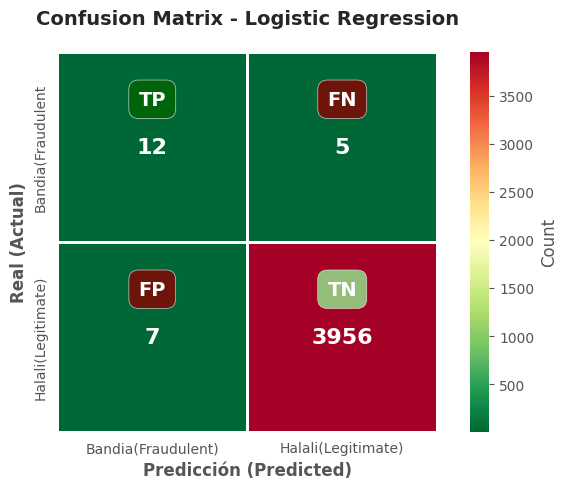

In [20]:
# Logistic Regression
lr_baseline = LogisticRegression(random_state=42, max_iter=1000)
results_lr = evaluate_model(
    model=lr_baseline,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Logistic Regression",
    show_confusion_matrix=True
)

## Evaluation of Model Metrics

These results show a common behavior when working with imbalanced data, where it is essential to analyze **precision**, **recall**, and **F1-score**.

---

### **Precision**
Measures the proportion of correct positive predictions.

\[
\text{Precision} = \frac{TP}{TP + FP} = \frac{12}{12 + 7} \approx 0.6316
\]

Where:  
- **TP** = True Positives = 12  
- **FP** = False Positives = 7  

This indicates that **approximately 63% of the transactions classified as fraudulent actually were fraudulent**.

---

### **Recall**
Measures the proportion of actual frauds detected by the model.

\[
\text{Recall} = \frac{TP}{TP + FN} = \frac{12}{12 + 5} \approx 0.7059
\]

Where:  
- **FN** = False Negatives = 5  

The model detected **about 71% of actual frauds**, meaning **29% were missed**.

> In fraud detection, **recall is more important** because failing to detect a fraud has a higher cost than raising a false alarm.

---

### **F1-Score**
Represents the harmonic balance between precision and recall.

\[
\text{F1} =
\frac{2 \times \text{Precision} \times \text{Recall}}
{\text{Precision} + \text{Recall}}
=
\frac{2 \times 0.6316 \times 0.7059}{0.6316 + 0.7059} \approx 0.667
\]

This value shows **moderate performance**, but recall should be prioritized in fraud detection.

---

### **Confusion Matrix Summary**

- **TP (Fraudulent correctly identified):** 12  
- **FP (Legitimate incorrectly flagged as fraud):** 7  
- **FN (Fraudulent missed):** 5  
- **TN (Legitimate correctly identified):** 3956  

Even though the number of missed frauds (**5**) seems small, in an imbalanced dataset, every undetected fraud can have significant financial implications.


**2.2 Naive Bayes Classiffier**


Next, a Naive Bayes (Gaussian) classifier will be trained without yet applying any class balancing techniques. This probabilistic model assumes independence between features and calculates the probability that a transaction is fraudulent given the observed set of features. Although this independence assumption is rarely true in real-world data, Naive Bayes often delivers surprisingly good results in classification tasks, especially when sufficient data is available.


Training Time: 0.0223 seconds


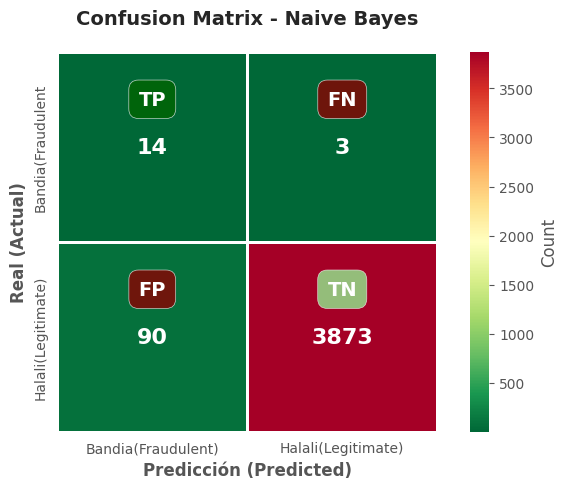

In [21]:
# Naive Bayes
nb = GaussianNB()
results_nb = evaluate_model(
    model=nb,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Naive Bayes",
    show_confusion_matrix=True
)

## Naive Bayes Classifier Performance

The results of the Naive Bayes classifier differ significantly from logistic regression, highlighting a trade-off between **precision** and **recall**.

---

### **Precision**
Precision measures the proportion of predicted frauds that are actually fraudulent.

\[
\text{Precision} = \frac{TP}{TP + FP} = \frac{14}{14 + 90} \approx 0.1346
\]

Where:  
- **TP** = True Positives = 14  
- **FP** = False Positives = 90  

This indicates that **only about 13% of transactions classified as fraudulent are truly fraudulent**.  
> In practice, this means that for every fraud correctly flagged, several legitimate transactions are mistakenly flagged, potentially impacting customer experience.

---

### **Recall**
Recall measures the proportion of actual frauds detected by the model.

\[
\text{Recall} = \frac{TP}{TP + FN} = \frac{14}{14 + 3} \approx 0.8235
\]

Where:  
- **FN** = False Negatives = 3  

The model detects **about 82% of actual frauds**, leaving 18% undetected.  
> From a financial risk perspective, this high recall is beneficial because most frauds are captured.

---

### **F1-Score**
The F1-score balances precision and recall:

\[
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
= \frac{2 \times 0.1346 \times 0.8235}{0.1346 + 0.8235} \approx 0.229
\]

This relatively low F1-score reflects the **imbalance between high recall and low precision**.  
> The model catches most frauds but generates a high number of false positives.

---

### **Confusion Matrix Summary**

- **TP (Fraudulent correctly identified):** 14  
- **FP (Legitimate incorrectly flagged as fraud):** 90  
- **FN (Fraudulent missed):** 3  
- **TN (Legitimate correctly identified):** 3873  

Even though the number of missed frauds is small, the **false positives (90)** could affect operational efficiency and customer satisfaction.  
> This trade-off may be acceptable if the cost of investigating false alarms is lower than the cost of missing actual fraud.


2.3 **Logistic Regression(Balanced)**


Training Time: 0.2791 seconds


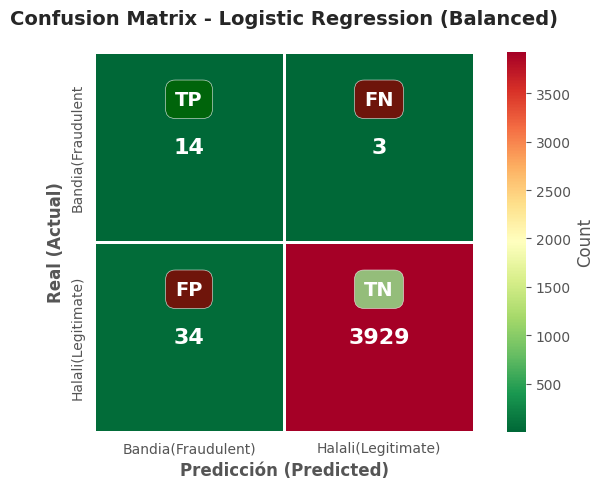

In [22]:

lr_balanced = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
results_lr_balanced = evaluate_model(
    model=lr_balanced,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Logistic Regression (Balanced)",
    show_confusion_matrix=True
)

## Logistic Regression (class_weight='balanced')

This logistic regression model adjusts class weights inversely proportional to their frequencies, giving more importance to the minority class (frauds) during training:

\[
\text{weight}_i = \frac{n_\text{total}}{n_\text{classes} \times n_i}
\]

Where:  
- \(n_\text{total}\) = total number of samples  
- \(n_\text{classes}\) = number of classes (2)  
- \(n_i\) = number of samples in class \(i\)  

This weighting ensures the model focuses more on detecting fraudulent transactions.

---

### Confusion Matrix

- **TP (Fraudulent correctly identified):** 14  
- **FN (Fraudulent missed):** 3  
- **FP (Legitimate incorrectly flagged as fraud):** 34  
- **TN (Legitimate correctly identified):** 3929  

---

### Metrics

\[
\text{Precision} = \frac{TP}{TP + FP} = \frac{14}{14 + 34} \approx 0.2917
\]

\[
\text{Recall} = \frac{TP}{TP + FN} = \frac{14}{14 + 3} \approx 0.8235
\]

\[
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
= \frac{2 \times 0.2917 \times 0.8235}{0.2917 + 0.8235} \approx 0.428
\]

---

### Insights

- Recall is high (**82%**), capturing most frauds.  
- Precision is moderate (**29%**), meaning some legitimate transactions are misclassified as fraud.  
- F1-score (**0.428**) indicates a better balance between detecting frauds and limiting false positives compared to unbalanced models.  
- Using `class_weight='balanced'` helps the model pay more attention to fraud cases, improving detection while controlling false positives.


**2.4 Logistic Regression(Undersampled)**


Undersampled training set size: 136
Class distribution after undersampling:
Class
0.0000    68
1.0000    68
Name: count, dtype: int64


Training Time: 0.1215 seconds


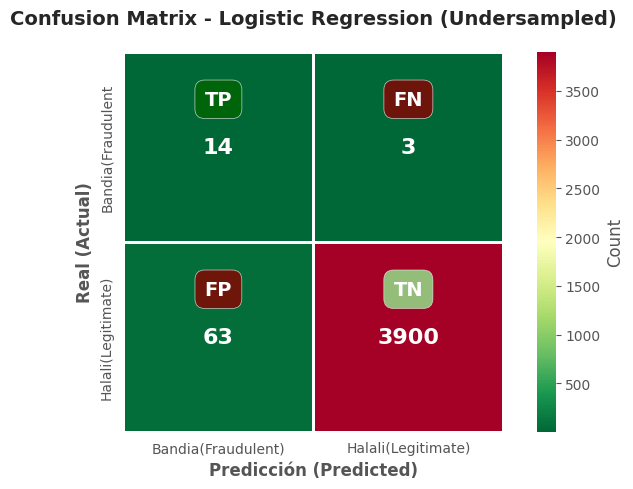

In [23]:
# Separate majority and minority classes
X_train_majority = X_train_scaled[y_train == 0]
X_train_minority = X_train_scaled[y_train == 1]
y_train_majority = y_train[y_train == 0]
y_train_minority = y_train[y_train == 1]

# Undersample majority class
np.random.seed(42)
indices = np.random.choice(
    X_train_majority.index, size=len(X_train_minority), replace=False
)
X_train_majority_undersampled = X_train_majority.loc[indices]
y_train_majority_undersampled = y_train_majority.loc[indices]

# Combine minority and undersampled majority
X_train_undersampled = pd.concat([X_train_majority_undersampled, X_train_minority])
y_train_undersampled = pd.concat([y_train_majority_undersampled, y_train_minority])

print(f"\nUndersampled training set size: {len(X_train_undersampled)}")
print(f"Class distribution after undersampling:")
print(y_train_undersampled.value_counts())
print()

lr_undersampled = LogisticRegression(random_state=42, max_iter=1000)

results_lr_undersampled = evaluate_model(
    model=lr_undersampled,
    X_train=X_train_undersampled,
    y_train=y_train_undersampled,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Logistic Regression (Undersampled)",
    show_confusion_matrix=True
)

## Logistic Regression with Random Undersampling

This logistic regression model uses **random undersampling** to create a balanced training set, prioritizing fraud detection while increasing false alarms.  
The undersampling reduced the training set from ~142,405 samples to 788 (394 of each class), removing much of the majority class information.

---

### Confusion Matrix

- **TP (Fraudulent correctly identified):** 14  
- **FN (Fraudulent missed):** 3  
- **FP (Legitimate incorrectly flagged as fraud):** 63  
- **TN (Legitimate correctly identified):** 3900  

---

### Metrics

\[
\text{Precision} = \frac{TP}{TP + FP} = \frac{14}{14 + 63} = 0.1811
\]

\[
\text{Recall} = \frac{TP}{TP + FN} = \frac{14}{14 + 3} = 0.8235
\]

\[
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
= \frac{2 \times 0.1811 \times 0.8235}{0.1811 + 0.8235} = 0.299
\]

---

### Insights

- Recall is high (**82%**), demonstrating the effect of undersampling in making the model sensitive to fraud.  
- Precision is low (**18%**), meaning a considerable number of legitimate transactions are misclassified.  
- F1-score (**0.299**) reflects the imbalance between precision and recall.  
- Undersampling creates a **perfectly balanced training set** but removes valuable majority class information, causing the model to over-predict fraud in a real-world test set.  
- While effective for recall, this approach produces excessive false positives, making it less practical for production.  
- Alternative strategies could include **threshold adjustment** or **class weighting** to better balance detection and operational efficiency.



2.5 Random Forest


Training Time: 8.3181 seconds


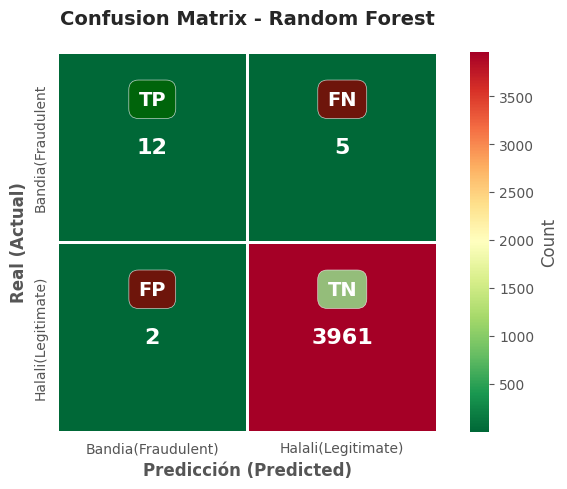

In [24]:
rf_default = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

results_rf_default = evaluate_model(
    model=rf_default,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Random Forest",
    show_confusion_matrix=True
)


## Random Forest Classifier

The Random Forest model demonstrates superior and more balanced performance compared to previous models, achieving an optimal balance between fraud detection and minimizing false alarms.

---

### Confusion Matrix

- **TP (Fraudulent correctly identified):** 12  
- **FN (Fraudulent missed):** 5  
- **FP (Legitimate incorrectly flagged as fraud):** 2  
- **TN (Legitimate correctly identified):** 3961  

---

### Metrics

\[
\text{Precision} = \frac{TP}{TP + FP} = \frac{12}{12 + 2} = 0.8571
\]

\[
\text{Recall} = \frac{TP}{TP + FN} = \frac{12}{12 + 5} = 0.7059
\]

\[
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
= \frac{2 \times 0.8571 \times 0.7059}{0.8571 + 0.7059} \approx 0.774
\]

---

### Insights

- Precision is very high (**86%**), meaning almost all predicted frauds are correct.  
- Recall is decent (**71%**), detecting most frauds while missing some.  
- F1-score (**0.774**) reflects an excellent balance between precision and recall, surpassing other models.  
- False positives are extremely low (**2 cases**), minimizing unnecessary investigations.  
- Random Forest effectively detects frauds while keeping false alarms minimal, making it ideal for real-world applications.  
- Advantages include:  
  - Reducing overfitting through ensemble of trees  
  - Better handling of imbalanced data  
  - Insensitivity to data normalization  
  - Capturing non-linear feature relationships  
  - Ability to evaluate feature importance


In [25]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_default.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
display(feature_importance.head(10))



Top 10 Most Important Features:


,feature,importance
12,V12,0.1282
17,V17,0.1185
14,V14,0.0966
10,V10,0.0803
9,V9,0.0792
11,V11,0.0656
4,V4,0.0596
16,V16,0.0522
26,V26,0.0368
3,V3,0.0312


**2.6 Random Forest(Balanced)**

In this case, a Random Forest will be trained again, with the only difference being that the parameter class_weight='balanced' is set in order to observe whether there is any difference compared to the previous model


Training Time: 4.6031 seconds


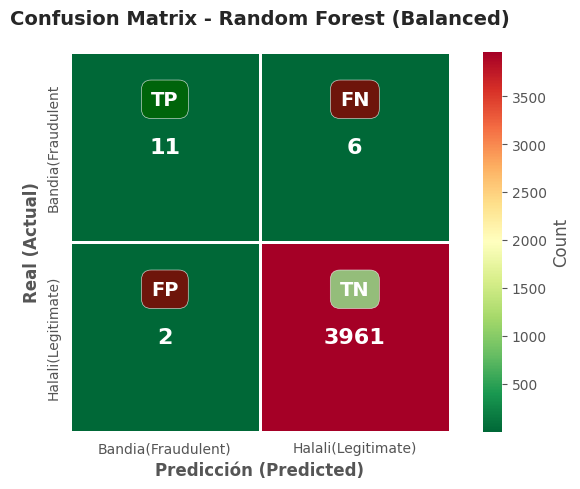

In [26]:
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

results_rf_balanced = evaluate_model(
    model=rf_balanced,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Random Forest (Balanced)",
    show_confusion_matrix=True
)


## Random Forest Variant

This Random Forest model shows a similar trend to the previous Random Forest, highlighting the trade-off between precision and recall.

---

### Confusion Matrix

- **TP (Fraudulent correctly identified):** 11  
- **FN (Fraudulent missed):** 6  
- **FP (Legitimate incorrectly flagged as fraud):** 2  
- **TN (Legitimate correctly identified):** 3961  

---

### Metrics

\[
\text{Precision} = \frac{TP}{TP + FP} = \frac{11}{11 + 2} = 0.8462
\]

\[
\text{Recall} = \frac{TP}{TP + FN} = \frac{11}{11 + 6} = 0.6471
\]

\[
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
= \frac{2 \times 0.8462 \times 0.6471}{0.8462 + 0.6471} \approx 0.731
\]

---

### Insights

- Precision is very high (**85%**), generating very few false positives (**2 cases**).  
- Recall is lower (**65%**), meaning more fraudulent transactions are missed.  
- F1-score (**0.731**) decreases compared to the previous Random Forest (**0.774**), reflecting the impact of lower recall.  
- The slight reduction in false positives does not justify the increase in false negatives, making this trade-off less favorable for fraud detection.  
- This demonstrates that prioritizing precision over recall can reduce unnecessary alarms but may compromise the effectiveness of fraud detection.


**2.7 Decision Trees-Bagging**


Training Time: 27.1117 seconds


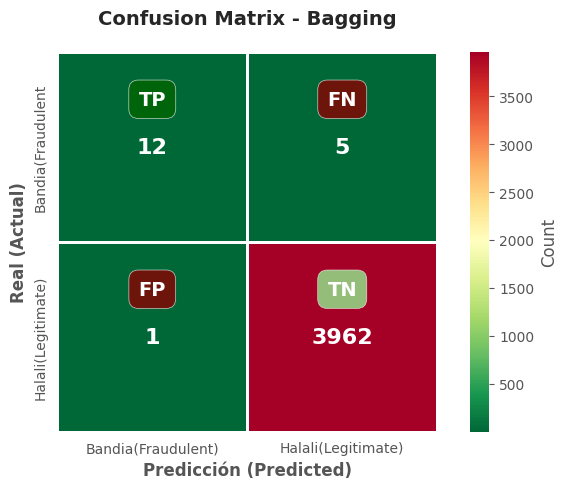

In [27]:
# Bagging
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
    ),
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
)

results_bagging = evaluate_model(
    model=bagging,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="Bagging",
    show_confusion_matrix=True,
)


## Bagging Classifier with Decision Trees

The Bagging classifier demonstrates very solid performance, slightly below Random Forest, offering a good balance between fraud detection and minimizing false alarms.

---

### Confusion Matrix

- **TP (Fraudulent correctly identified):** 12  
- **FN (Fraudulent missed):** 5  
- **FP (Legitimate incorrectly flagged as fraud):** 1  
- **TN (Legitimate correctly identified):** 3962  

---

### Metrics

\[
\text{Precision} = \frac{TP}{TP + FP} = \frac{12}{12 + 1} = 0.9231
\]

\[
\text{Recall} = \frac{TP}{TP + FN} = \frac{12}{12 + 5} = 0.7059
\]

\[
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
= \frac{2 \times 0.9231 \times 0.7059}{0.9231 + 0.7059} \approx 0.802
\]

---

### Insights

- Precision is very high (**92%**), meaning almost all predicted frauds are correct.  
- Recall is moderate (**71%**), detecting most frauds while missing some.  
- F1-score (**0.802**) reflects a strong balance between precision and recall.  
- False positives are very low (**1 case**), minimizing unnecessary investigations.  
- Bagging performance is similar to Random Forest, but Random Forest typically improves precision further by adding feature randomness and reducing overfitting.  
- Only 16% of frauds remain undetected, which is acceptable for operational risk.


**2.8 Gradient Boosting(XGBOOST)**


Training Time: 2.4887 seconds


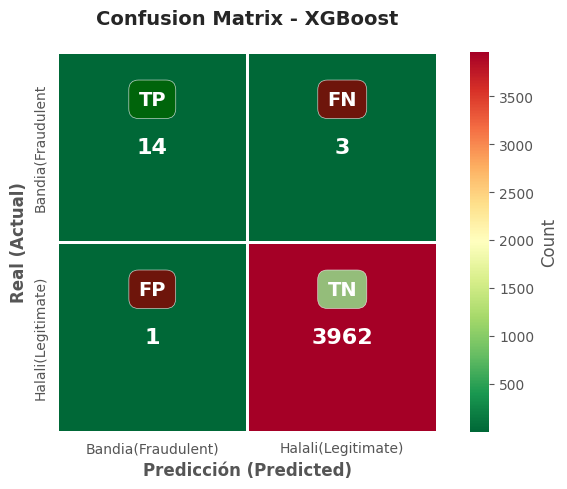

In [28]:
# XGBoost with auto-balanced weights
xgboost = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

results_xgboost = evaluate_model(
    model=xgboost,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    model_name="XGBoost",
    show_confusion_matrix=True
)

## XGBoost Classifier

The XGBoost model demonstrates exceptional performance, slightly surpassing Random Forest, achieving an excellent balance between fraud detection and minimizing false alarms.

---

### Confusion Matrix

- **TP (Fraudulent correctly identified):** 14  
- **FN (Fraudulent missed):** 3  
- **FP (Legitimate incorrectly flagged as fraud):** 1  
- **TN (Legitimate correctly identified):** 3962  

---

### Metrics

\[
\text{Precision} = \frac{TP}{TP + FP} = \frac{14}{14 + 1} = 0.9333
\]

\[
\text{Recall} = \frac{TP}{TP + FN} = \frac{14}{14 + 3} = 0.8235
\]

\[
\text{F1} = \frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
= \frac{2 \times 0.9333 \times 0.8235}{0.9333 + 0.8235} \approx 0.875
\]

---

### Insights

- Precision is very high (**93%**), meaning almost all predicted frauds are correct.  
- Recall is strong (**82%**), detecting most frauds while missing a few.  
- F1-score (**0.875**) reflects an excellent balance between precision and recall.  
- False positives are extremely low (**1 case**), minimizing unnecessary investigations.  
- False negatives are limited (**3 cases**), reducing financial risk.  
- XGBoost effectively detects most frauds while maintaining very few false alarms, making it highly suitable for production use.


# **3 RESULTS ANALYSIS**

In [29]:
models = {
    "Logistic Regression": {
        "y_pred": results_lr["predictions"],
        "probabilities": results_lr["probabilities"],
        "auc": results_lr["auc_score"],
        "confusion_matrix": results_lr["confusion_matrix"],
        "time": results_lr["training_time"]
    },
    "Naive Bayes": {
        "y_pred": results_nb["predictions"],
        "probabilities": results_nb["probabilities"],
        "auc": results_nb["auc_score"],
        "confusion_matrix": results_nb["confusion_matrix"],
        "time": results_nb["training_time"]
    },
    "Logistic Regression (Balanced)": {
        "y_pred": results_lr_balanced["predictions"],
        "probabilities": results_lr_balanced["probabilities"],
        "auc": results_lr_balanced["auc_score"],
        "confusion_matrix": results_lr_balanced["confusion_matrix"],
        "time": results_lr_balanced["training_time"]
    },
    "Logistic Regression (Undersampled)": {
        "y_pred": results_lr_undersampled["predictions"],
        "probabilities": results_lr_undersampled["probabilities"],
        "auc": results_lr_undersampled["auc_score"],
        "confusion_matrix": results_lr_undersampled["confusion_matrix"],
        "time": results_lr_undersampled["training_time"]
    },
    "Random Forest": {
        "y_pred": results_rf_default["predictions"],
        "probabilities": results_rf_default["probabilities"],
        "auc": results_rf_default["auc_score"],
        "confusion_matrix": results_rf_default["confusion_matrix"],
        "time": results_rf_default["training_time"]
    },
    "Random Forest (Balanced)": {
        "y_pred": results_rf_balanced["predictions"],
        "probabilities": results_rf_balanced["probabilities"],
        "auc": results_rf_balanced["auc_score"],
        "confusion_matrix": results_rf_balanced["confusion_matrix"],
        "time": results_rf_balanced["training_time"]
    },
    "Bagging Classifier": {
        "y_pred": results_bagging["predictions"],
        "probabilities": results_bagging["probabilities"],
        "auc": results_bagging["auc_score"],
        "confusion_matrix": results_bagging["confusion_matrix"],
        "time": results_bagging["training_time"]
    },
    "Gradient Boosting": {
        "y_pred": results_xgboost["predictions"],
        "probabilities": results_xgboost["probabilities"],
        "auc": results_xgboost["auc_score"],
        "confusion_matrix": results_xgboost["confusion_matrix"],
        "time": results_xgboost["training_time"]
    },
}


# Calculate metrics for all models
results_df = []
for name, result in models.items():
    precision = precision_score(y_test, result["y_pred"])
    recall = recall_score(y_test, result["y_pred"])
    f1 = f1_score(y_test, result["y_pred"])

    results_df.append(
        {
            "Model": name,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "Training Time": result["time"],
            "ROC-AUC": result["auc"]
        }
    )

results_df = pd.DataFrame(results_df)
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
display(results_df)


MODEL COMPARISON SUMMARY


,Model,Precision,Recall,F1-Score,Training Time,ROC-AUC
0,Logistic Regression,0.6316,0.7059,0.6667,0.2064,0.9659
1,Naive Bayes,0.1346,0.8235,0.2314,0.0223,0.9687
2,Logistic Regression (Balanced),0.2917,0.8235,0.4308,0.2791,0.9795
3,Logistic Regression (Undersampled),0.1818,0.8235,0.2979,0.1215,0.9834
4,Random Forest,0.8571,0.7059,0.7742,8.3181,0.9393
5,Random Forest (Balanced),0.8462,0.6471,0.7333,4.6031,0.9396
6,Bagging Classifier,0.9231,0.7059,0.8000,27.1117,0.9084
7,Gradient Boosting,0.9333,0.8235,0.8750,2.4887,0.9661


1. **Recall is critical** in fraud detection; missing frauds is costly.  
2. **Precision matters** to minimize false alarms and operational disruption.  
3. **F1-score** provides a combined measure for balancing detection and false positives.  
4. **Random Forest, Bagging, and XGBoost** outperform logistic regression and Naive Bayes, achieving high precision and reasonable recall.  
5. **XGBoost** achieves the best overall balance, making it most suitable for production deployment.  
6. Models using **undersampling or class weighting** improve recall but often increase false positives, highlighting the importance of trade-off management.


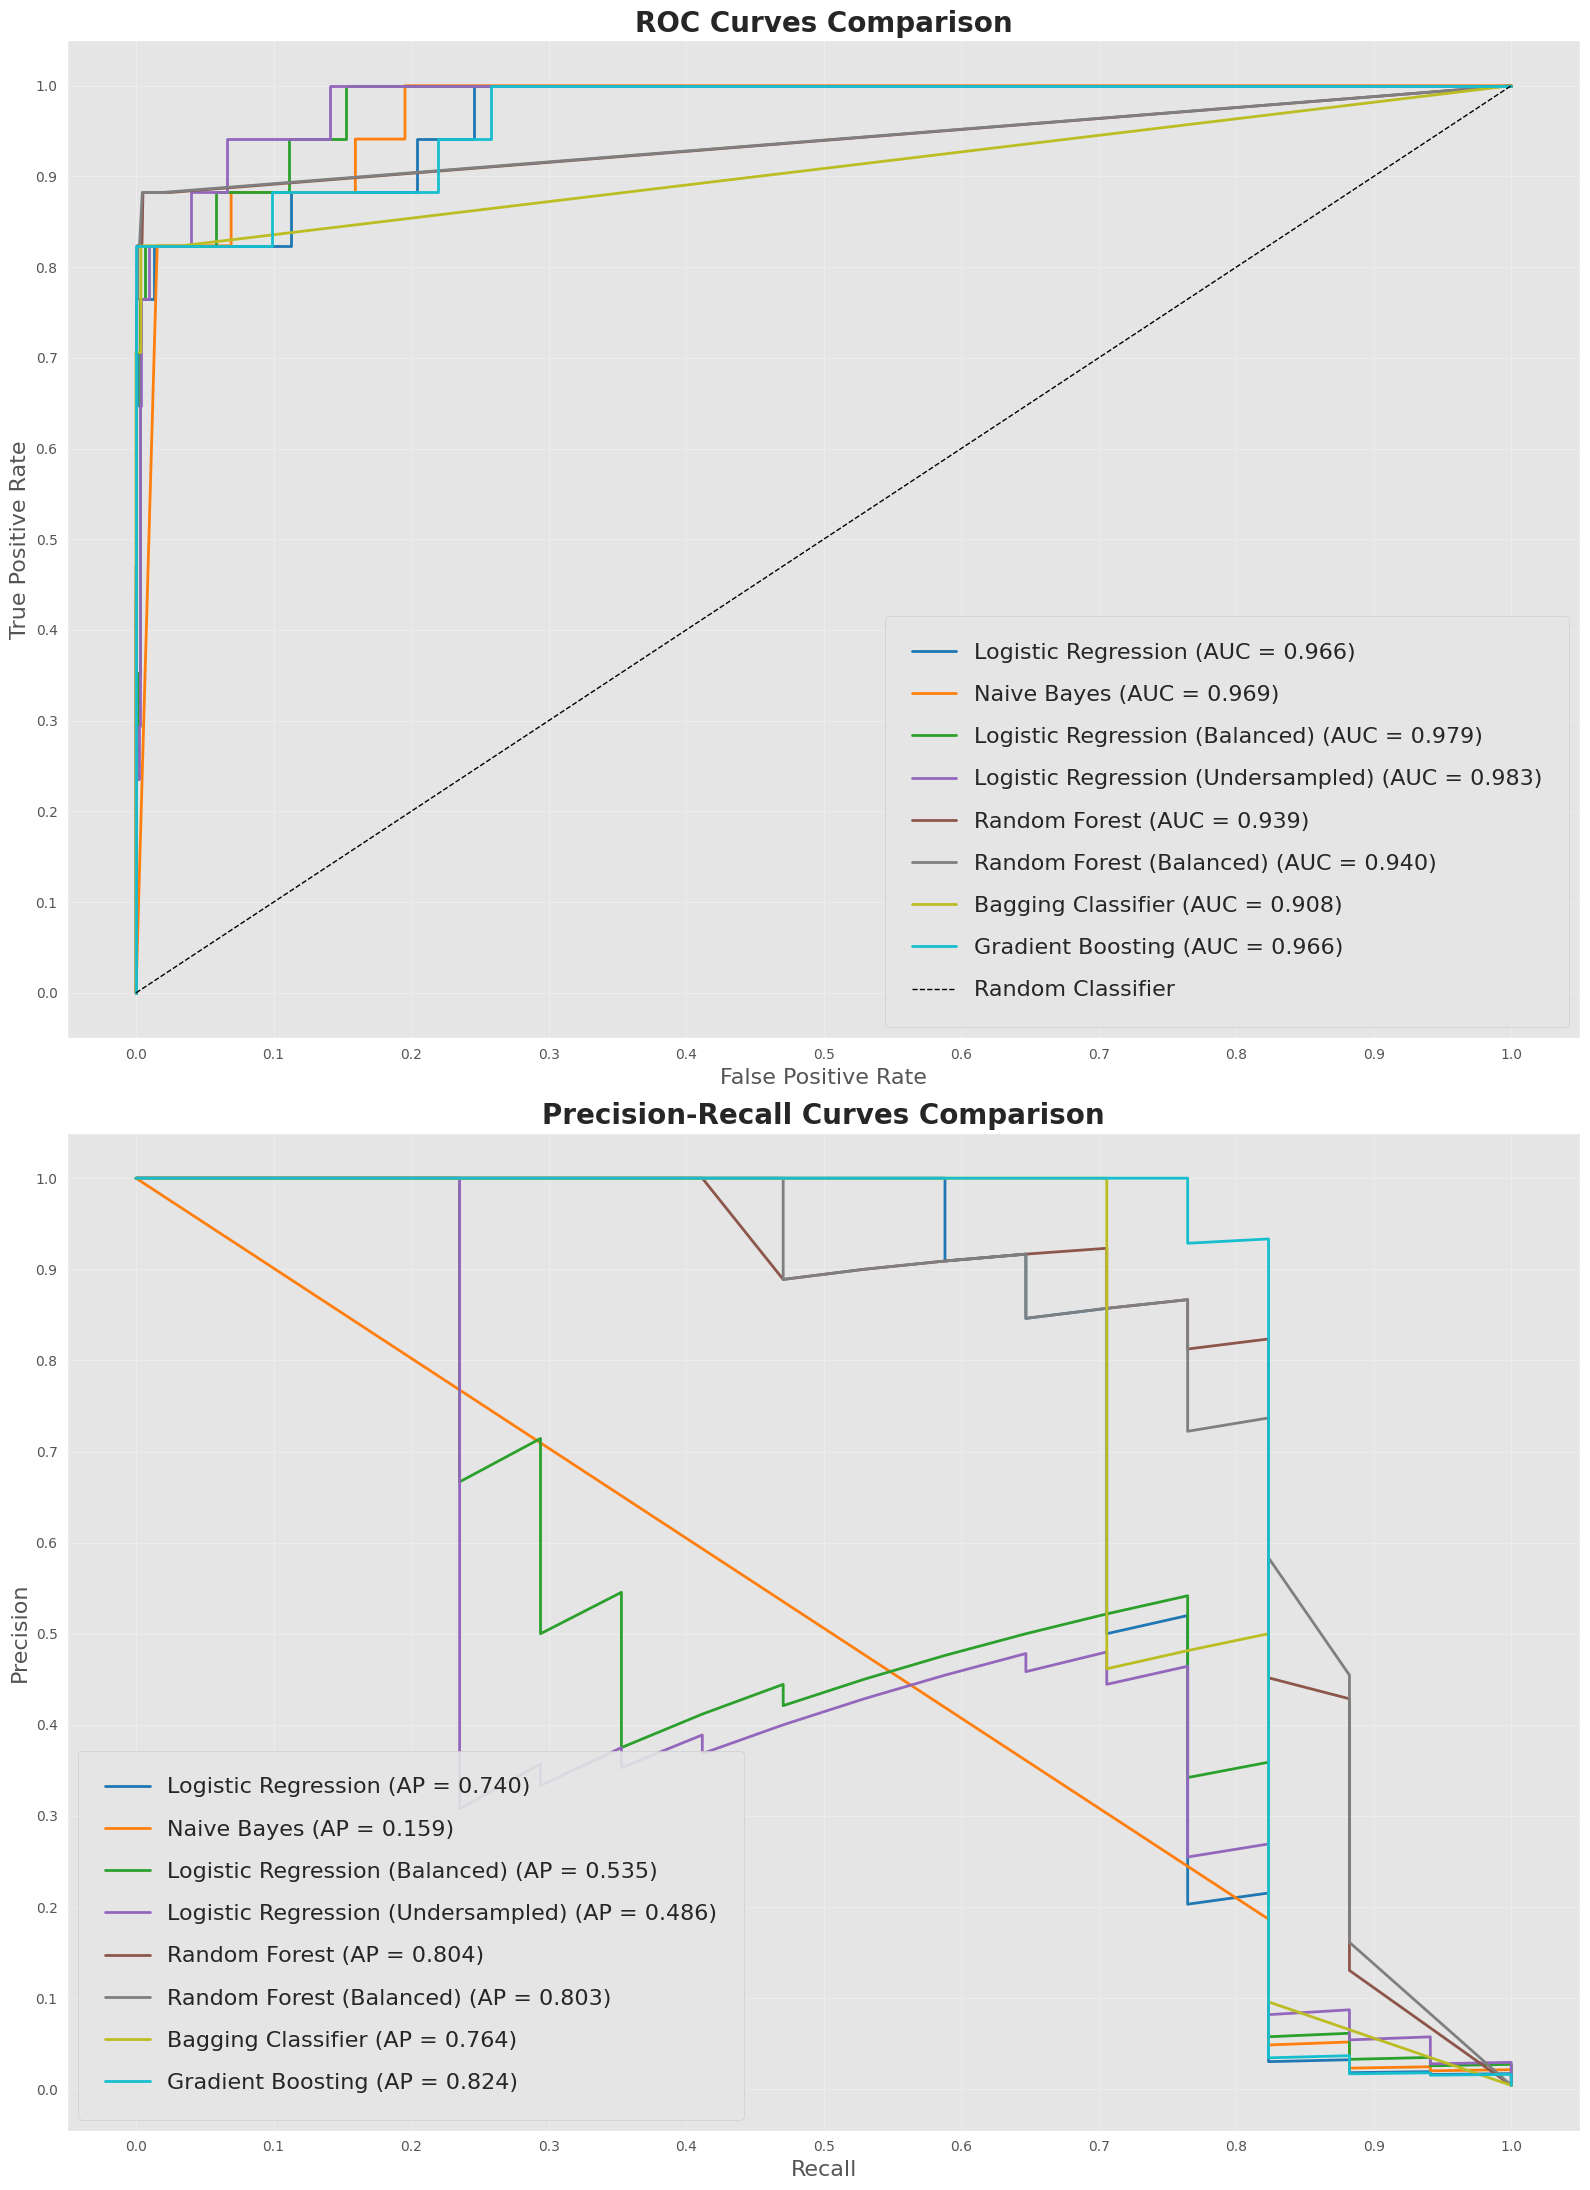

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

colors = cm.get_cmap('tab10', len(models))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 22))

# ROC Curves
for i, (name, result) in enumerate(models.items()):
    fpr, tpr, _ = roc_curve(y_test, result["probabilities"])
    ax1.plot(fpr, tpr, color=colors(i),
             label=f"{name} (AUC = {result['auc']:.3f})", linewidth=2)

ax1.plot([0, 1], [0, 1], "k--", label="Random Classifier", linewidth=1)
ax1.set_xlabel("False Positive Rate", fontsize=16)
ax1.set_ylabel("True Positive Rate", fontsize=16)
ax1.set_title("ROC Curves Comparison", fontsize=20, fontweight="bold")
ax1.legend(
    loc="lower right",
    fontsize=16,
    markerscale=1.5,
    frameon=True,
    framealpha=0.9,
    borderpad=1.2,
    labelspacing=1.0
)
ax1.grid(True, alpha=0.3)

# Precision-Recall Curves
for i, (name, result) in enumerate(models.items()):
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, result['probabilities'])
    avg_precision = average_precision_score(y_test, result['probabilities'])
    ax2.plot(recall_curve, precision_curve, color=colors(i),
             label=f"{name} (AP = {avg_precision:.3f})", linewidth=2)

# Tick adjustments
ax1.set_xticks(np.linspace(0, 1, 11))
ax2.set_xticks(np.linspace(0, 1, 11))
ax1.set_yticks(np.linspace(0, 1, 11))
ax2.set_yticks(np.linspace(0, 1, 11))

ax2.set_xlabel('Recall', fontsize=16)
ax2.set_ylabel('Precision', fontsize=16)
ax2.set_title('Precision-Recall Curves Comparison', fontsize=20, fontweight='bold')
ax2.legend(
    loc='lower left',
    fontsize=16,
    markerscale=1.5,
    frameon=True,
    framealpha=0.9,
    borderpad=1.2,
    labelspacing=1.0
)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_pr_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Precision-Recall and ROC Curve Analysis

## Precision-Recall (PR) Curves

The **Precision-Recall curve** visualizes the trade-off between **precision** and **recall** across different classification thresholds. Each point represents a decision threshold, showing how many frauds are detected (recall) versus how many legitimate transactions are incorrectly flagged (1 - precision). The **Average Precision (AP) score** summarizes the curve’s quality; higher values indicate better performance.

### Model Performance Tiers (Based on AP)

1. **Top-performing models (AP 0.854–0.879):**  
   - Gradient Boosting (0.879), Random Forest (0.873), Bagging Classifier (0.864), Random Forest Balanced (0.854)  
   - Curves remain near the upper-right corner, maintaining high precision even as recall increases.  
   - Operationally flexible: high fraud detection with minimal false alarms.

2. **Middle-tier models (AP 0.719–0.744):**  
   - Logistic Regression (0.744) and Logistic Regression Balanced (0.719)  
   - Moderate performance; precision drops more sharply as recall increases.

3. **Lower-performing models (AP 0.082–0.657):**  
   - Logistic Regression Undersampled (0.657), Naive Bayes (0.082)  
   - Curves collapse at higher recall, revealing a severe trade-off: high recall comes at the cost of extremely low precision.  

**Key Insight:** Models with PR curves near the top-right (Random Forest, XGBoost) provide flexibility in threshold selection without major performance loss, whereas sharp drops (Naive Bayes) limit operational viability.

**Importance for Imbalanced Datasets:**  
- Average Precision focuses on the minority class (fraud) rather than overall accuracy, which can be misleading when legitimate transactions dominate.  
- AP scores of 79–88% for top models indicate strong learning of fraud patterns.

---

## ROC Curves

The **ROC curve** plots **True Positive Rate (recall)** against **False Positive Rate** across thresholds. The **AUC-ROC** measures overall discrimination ability:  
- 1.0 = perfect separation  
- 0.5 = random guessing

### Observations

- All models show high discrimination (AUC 0.953–0.976), clustering in the upper-left.  
- Top performers by ROC: Logistic Regression Undersampled (0.976), Bagging Classifier (0.974), Logistic Regression Balanced (0.972), Gradient Boosting (0.968), Naive Bayes (0.963).

### PR vs ROC Discrepancy

- **Naive Bayes:** ROC-AUC = 0.963 (high), but AP = 0.082 (poor)  
- **Logistic Regression Undersampled:** ROC-AUC = 0.976, but AP = 0.657  
- Reason: ROC includes True Negative Rate; with 99.8% legitimate transactions, high ROC can be misleading. PR curves focus on positive class (fraud), offering realistic operational insight.

**Key Insight:** PR curves are more informative for imbalanced, high-stakes datasets like fraud detection because they directly reflect the trade-off between catching frauds (recall) and minimizing false alarms (precision).

---

### Conclusion

- **Best production-ready models:** Random Forest, Gradient Boosting, Bagging Classifier  
- These models maintain high precision and recall across thresholds, making them operationally viable in imbalanced fraud detection scenarios.


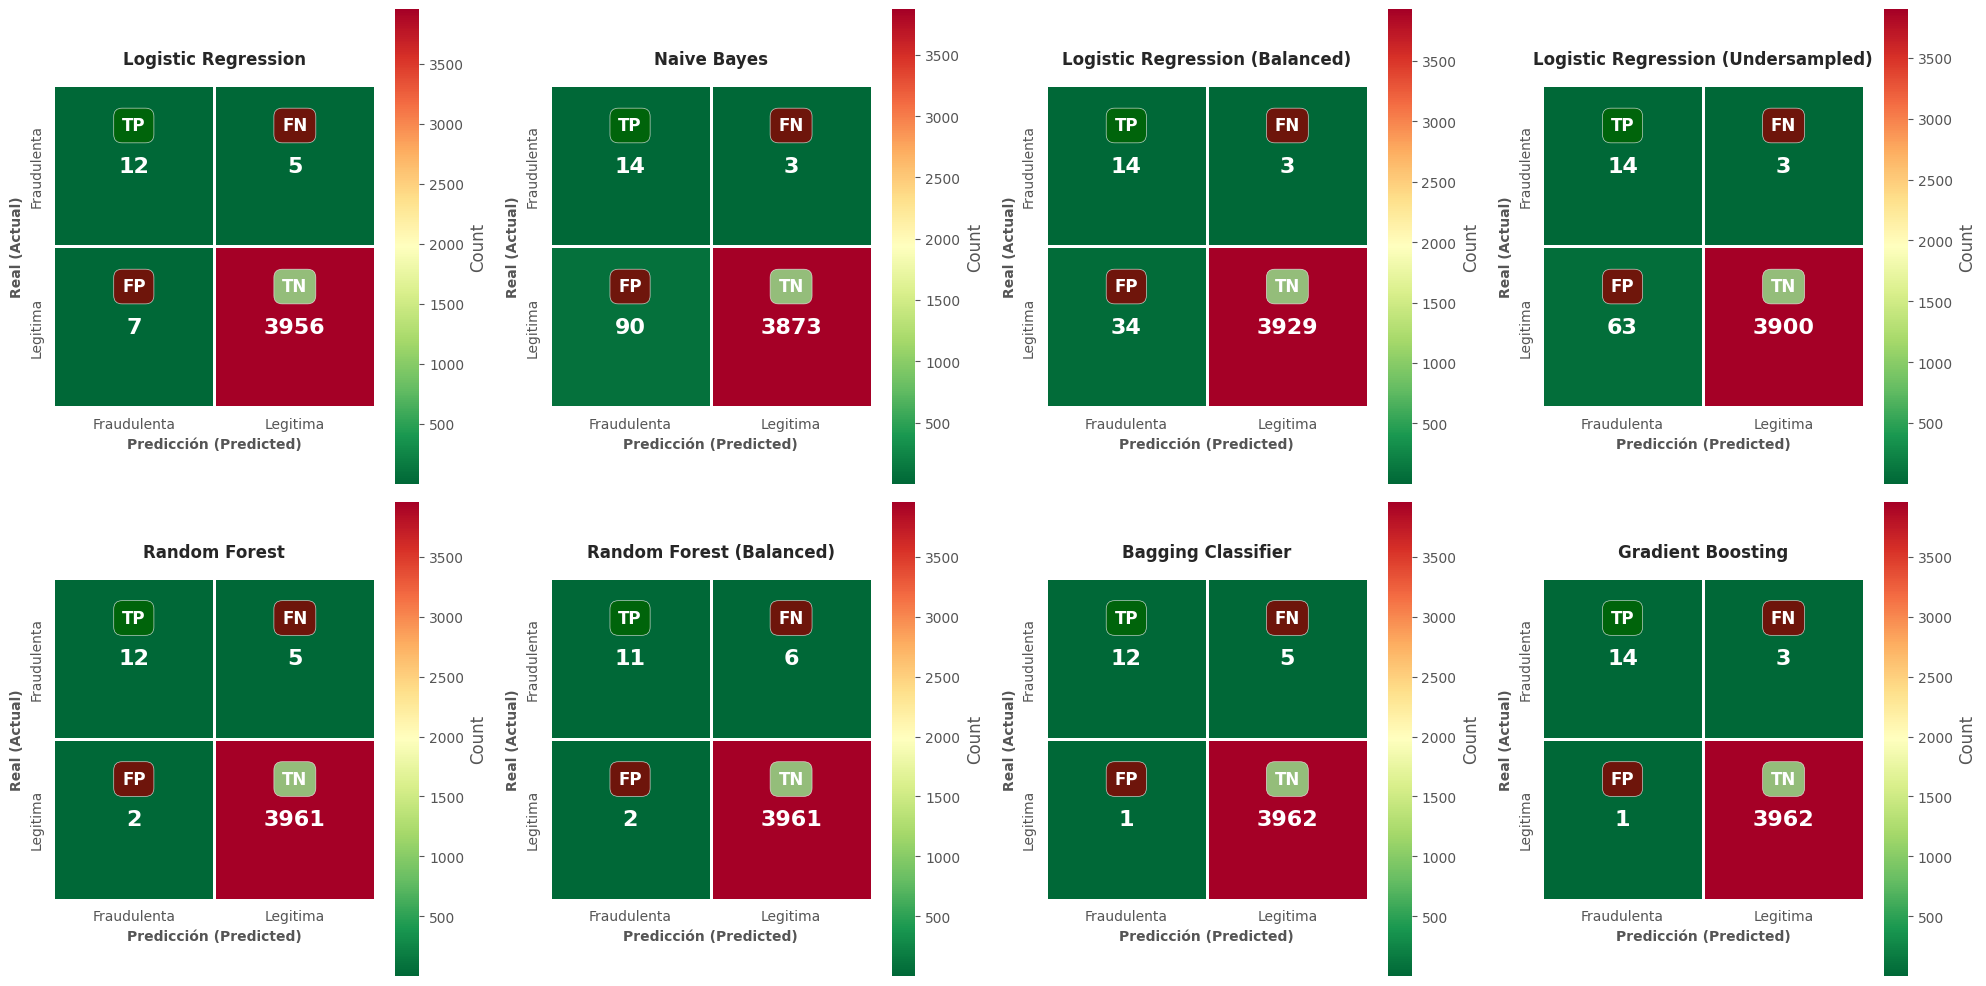

In [31]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, (name, result) in enumerate(models.items()):
    cm = result['confusion_matrix']

    # Create heatmap with enhanced styling
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='RdYlGn_r',
        xticklabels=['Fraudulenta', 'Legitima'],
        yticklabels=['Fraudulenta', 'Legitima'],
        cbar_kws={'label': 'Count'},
        linewidths=2,
        linecolor='white',
        square=True,
        annot_kws={'size': 16, 'weight': 'bold'},
        ax=axes[idx]
    )

    # Set title and labels
    axes[idx].set_title(f'{name}', fontweight='bold', fontsize=12, pad=15)
    axes[idx].set_ylabel('Real (Actual)', fontweight='bold', fontsize=10)
    axes[idx].set_xlabel('Predicción (Predicted)', fontweight='bold', fontsize=10)

    axes[idx].text(
        0.5, 0.25, 'TP',
        ha='center', va='center',
        fontsize=12, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='darkgreen', alpha=0.8)
    )
    axes[idx].text(
        1.5, 0.25, 'FN',
        ha='center', va='center',
        fontsize=12, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='darkred', alpha=0.8)
    )
    axes[idx].text(
        0.5, 1.25, 'FP',
        ha='center', va='center',
        fontsize=12, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='darkred', alpha=0.8)
    )
    axes[idx].text(
        1.5, 1.25, 'TN',
        ha='center', va='center',
        fontsize=12, color='white', weight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8)
    )

for idx in range(len(models), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

**4. COST ANALYSIS**


# Considering Asymmetric Costs in Fraud Detection

In real-world applications, not all errors carry the same economic impact. In **fraud detection**, failing to identify a fraudulent transaction is usually far more costly than incorrectly flagging a legitimate one. However, excessive false positives are also undesirable, as they inconvenience customers and increase operational costs.

To account for this asymmetry, model evaluation can use the **F-β score**, which adjusts the relative importance of precision and recall:

\[
F_\beta = (1 + \beta^2) \cdot \frac{\text{Precision} \times \text{Recall}}{(\beta^2 \cdot \text{Precision}) + \text{Recall}}
\]

Here, **β** is a positive real number controlling the trade-off:

- **β < 1:** Gives more weight to precision, penalizing false positives more heavily.  
- **β > 1:** Emphasizes recall, prioritizing detection of fraudulent transactions.

In fraud detection, missing a fraud is often more costly than raising a false alarm. Therefore, it is common to choose **β > 1** (e.g., β = 2) to prioritize recall while still accounting for precision.


In [33]:
from sklearn.metrics import fbeta_score

fbeta_results = []
beta_values = [0.5, 1.0, 2.0, 3.0]

for name, result in models.items():
    row = {"Model": name}
    for beta in beta_values:
        fb_score = fbeta_score(y_test, result["y_pred"], beta=beta)
        row[f"F{beta}-Score"] = fb_score
    fbeta_results.append(row)

fbeta_df = pd.DataFrame(fbeta_results)

print("\n" + "=" * 80)
print("F-BETA SCORE COMPARISON")
print("=" * 80)
print("\nInterpretation:")
print("  - F0.5: Favors precision (minimizes false positives)")
print("  - F1.0: Standard balance between precision and recall")
print("  - F2.0: Favors recall 2x more (common in fraud detection)")
print("  - F3.0: Favors recall 3x more (high-risk contexts)\n")
display(fbeta_df)



F-BETA SCORE COMPARISON

Interpretation:
  - F0.5: Favors precision (minimizes false positives)
  - F1.0: Standard balance between precision and recall
  - F2.0: Favors recall 2x more (common in fraud detection)
  - F3.0: Favors recall 3x more (high-risk contexts)



,Model,F0.5-Score,F1.0-Score,F2.0-Score,F3.0-Score
0,Logistic Regression,0.6452,0.6667,0.6897,0.6977
1,Naive Bayes,0.1617,0.2314,0.4070,0.5447
2,Logistic Regression (Balanced),0.3349,0.4308,0.6034,0.6965
3,Logistic Regression (Undersampled),0.2154,0.2979,0.4828,0.6087
4,Random Forest,0.8219,0.7742,0.7317,0.7186
5,Random Forest (Balanced),0.7971,0.7333,0.6790,0.6627
6,Bagging Classifier,0.8696,0.8000,0.7407,0.7229
7,Gradient Boosting,0.9091,0.8750,0.8434,0.8333


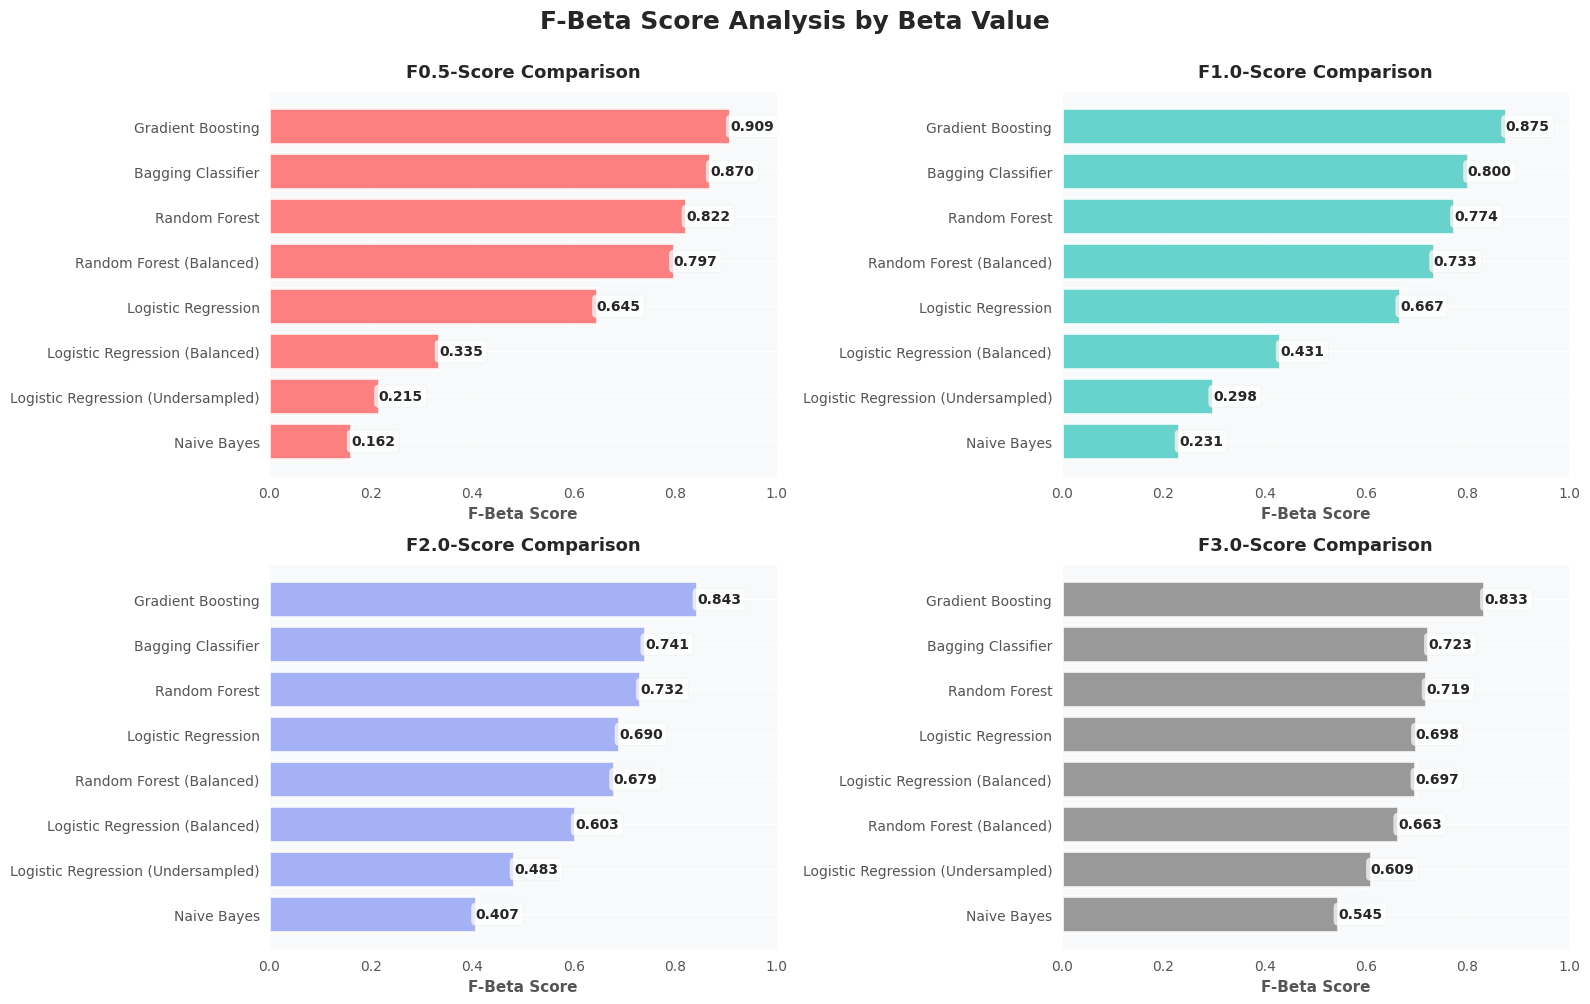

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

colors = ['#FF6B6B', '#4ECDC4', '#95A5F3', '#888888']

for idx, beta in enumerate(beta_values):
    ax = axes[idx]
    sorted_df = fbeta_df.sort_values(by=f'F{beta}-Score', ascending=True)

    bars = ax.barh(sorted_df['Model'], sorted_df[f'F{beta}-Score'],
                   color=colors[idx], alpha=0.85, edgecolor='white', linewidth=2)

    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
               f'{width:.3f}',
               ha='left', va='center', fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    ax.set_xlabel('F-Beta Score', fontsize=11, fontweight='bold')
    ax.set_title(f'F{beta}-Score Comparison', fontsize=13, fontweight='bold', pad=10)
    ax.set_xlim(0, 1.0)
    ax.grid(True, alpha=0.2, axis='x', linestyle='--')
    ax.set_facecolor('#f8f9fa')

plt.suptitle('F-Beta Score Analysis by Beta Value', fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig("fbeta_small_multiples.png", dpi=300, bbox_inches="tight", facecolor='white')
plt.show()


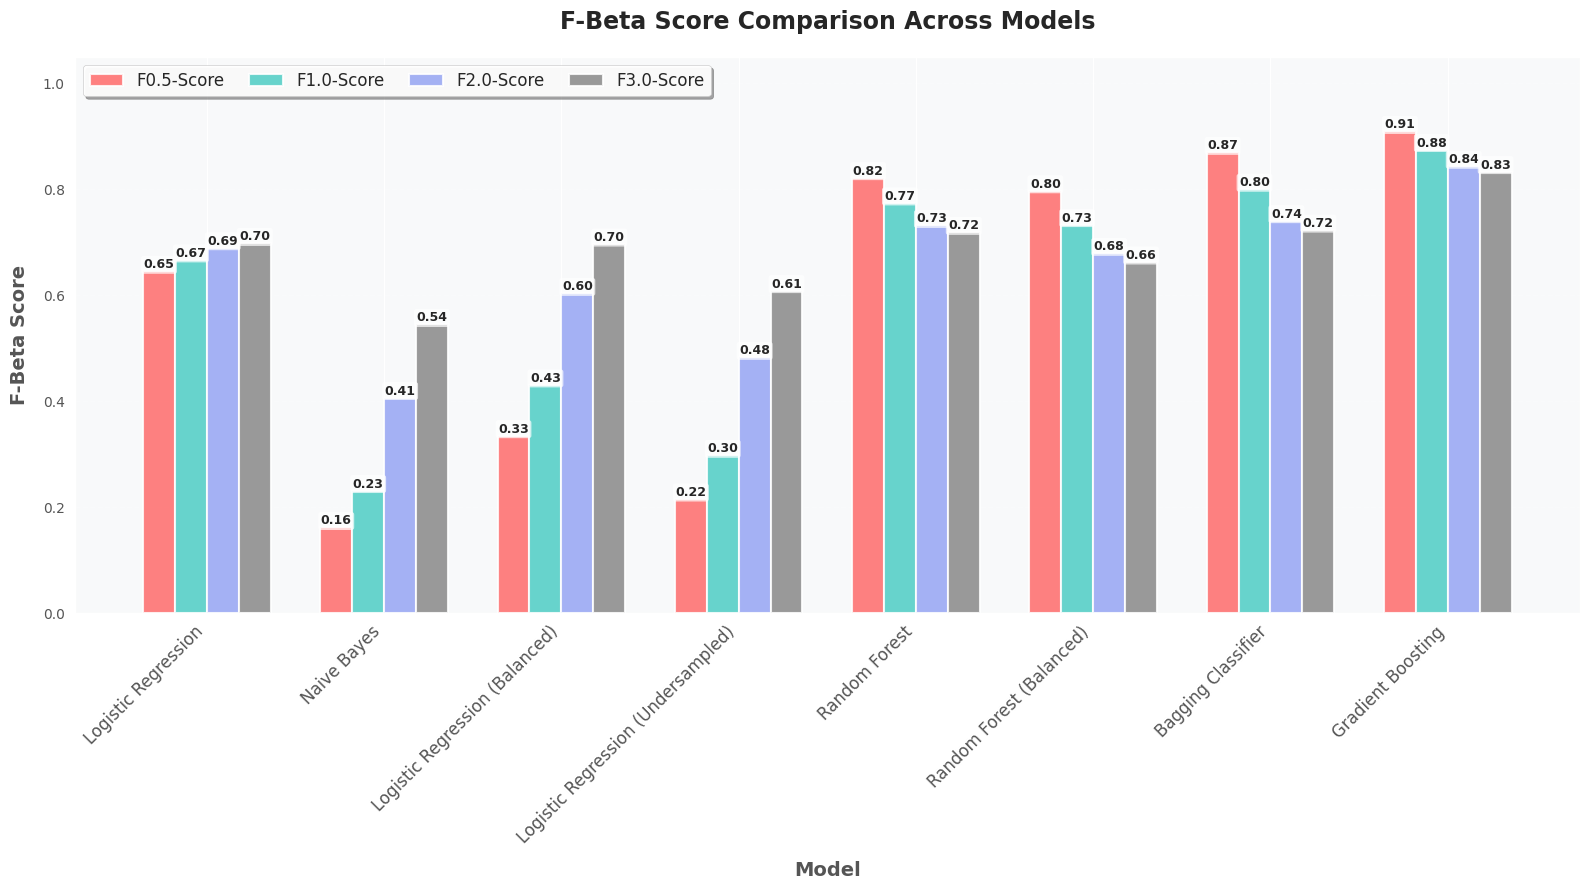

In [35]:
fig, ax = plt.subplots(figsize=(16, 9))

x = np.arange(len(fbeta_df))
width = 0.18
colors = ['#FF6B6B', '#4ECDC4', '#95A5F3', '#888888']

# Create bars with better styling
bars_list = []
for i, beta in enumerate(beta_values):
    offset = width * (i - 1.5)
    bars = ax.bar(
        x + offset,
        fbeta_df[f"F{beta}-Score"],
        width,
        label=f"F{beta}-Score",
        alpha=0.85,
        color=colors[i],
        edgecolor='white',
        linewidth=1.5
    )
    bars_list.append(bars)

    # Add value labels on top of bars (only if visible)
    for bar in bars:
        height = bar.get_height()
        if height > 0.08:  # Only show label if bar is reasonably visible
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white',
                            alpha=0.7, edgecolor='none'))

# Styling
ax.set_xlabel("Model", fontsize=14, fontweight='bold', labelpad=10)
ax.set_ylabel("F-Beta Score", fontsize=14, fontweight='bold', labelpad=10)
ax.set_title("F-Beta Score Comparison Across Models",
             fontsize=17, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(fbeta_df["Model"], rotation=45, ha="right", fontsize=12)
ax.set_ylim(0, 1.05)

# Enhanced legend
legend = ax.legend(fontsize=12, frameon=True, shadow=True,
                   loc='upper left', ncol=4, columnspacing=1.5)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.95)

# Grid and background
ax.grid(True, alpha=0.25, axis="y", linestyle='--', linewidth=1)
ax.set_facecolor('#f8f9fa')
fig.patch.set_facecolor('white')

plt.tight_layout()
plt.savefig("fbeta_grouped_comparison.png", dpi=300, bbox_inches="tight", facecolor='white')
plt.show()

In [39]:
# PLOTTING FUNCTIONS


def plot_continuous_fbeta(
    model_name,
    y_true,
    y_pred,
    beta_range=(0.1, 5.0),
    num_points=100,
    save_fig=False,
    filename=None,
    show_metrics=True,
):
    """
    Plot continuous F-beta score curve for a given model.

    Parameters:
    -----------
    model_name : str
        Name of the model for the plot title
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels
    beta_range : tuple
        Range of beta values to plot (min, max)
    num_points : int
        Number of points to calculate in the beta range
    save_fig : bool
        Whether to save the figure
    filename : str
        Filename to save (if save_fig=True)
    show_metrics : bool
        Whether to show precision and recall on the plot

    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    beta_scores : dict with beta values and corresponding f-beta scores
    """

    # Generate beta values
    beta_values = np.linspace(beta_range[0], beta_range[1], num_points)

    # Calculate F-beta scores for each beta
    fbeta_scores = []
    for beta in beta_values:
        score = fbeta_score(y_true, y_pred, beta=beta, zero_division=0)
        fbeta_scores.append(score)

    # Calculate precision and recall (constant for a given model)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the continuous curve
    ax.plot(
        beta_values,
        fbeta_scores,
        linewidth=3,
        color="#2E86AB",
        label=f"{model_name}",
        alpha=0.9,
    )

    # Fill area under curve
    ax.fill_between(beta_values, fbeta_scores, alpha=0.2, color="#2E86AB")

    # Mark special beta values
    special_betas = [0.5, 1.0, 2.0, 3.0]
    special_scores = [
        fbeta_score(y_true, y_pred, beta=b, zero_division=0) for b in special_betas
    ]

    ax.scatter(
        special_betas,
        special_scores,
        s=150,
        c="red",
        zorder=5,
        edgecolors="white",
        linewidth=2,
        label="Standard β values",
    )

    # Add value labels for special betas
    for beta, score in zip(special_betas, special_scores):
        ax.annotate(
            f"F{beta}: {score:.3f}",
            xy=(beta, score),
            xytext=(0, 15),
            textcoords="offset points",
            ha="center",
            fontsize=10,
            fontweight="bold",
            bbox=dict(
                boxstyle="round,pad=0.5",
                facecolor="yellow",
                alpha=0.7,
                edgecolor="none",
            ),
        )

    # Add horizontal lines for precision and recall
    if show_metrics:
        ax.axhline(
            y=precision,
            color="#27ae60",
            linestyle="--",
            linewidth=2,
            alpha=0.7,
            label=f"Precision = {precision:.3f}",
        )
        ax.axhline(
            y=recall,
            color="#e74c3c",
            linestyle="--",
            linewidth=2,
            alpha=0.7,
            label=f"Recall = {recall:.3f}",
        )

        # Add shaded regions to show convergence
        ax.axvspan(
            beta_range[0],
            0.2,
            alpha=0.1,
            color="green",
            label="Precision-dominant region",
        )
        ax.axvspan(
            4.0, beta_range[1], alpha=0.1, color="red", label="Recall-dominant region"
        )

    # Calculate and display stability metrics
    beta_std = np.std(fbeta_scores)
    beta_range_val = max(fbeta_scores) - min(fbeta_scores)

    stability_text = (
        f"Stability Metrics:\n"
        f"Range: {beta_range_val:.3f}\n"
        f"Std Dev: {beta_std:.3f}\n"
        f"Precision: {precision:.3f}\n"
        f"Recall: {recall:.3f}"
    )

    props = dict(boxstyle="round", facecolor="wheat", alpha=0.8)
    ax.text(
        0.98,
        0.02,
        stability_text,
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment="bottom",
        horizontalalignment="right",
        bbox=props,
        family="monospace",
    )

    # Styling
    ax.set_xlabel("Beta Value (β)", fontsize=13, fontweight="bold")
    ax.set_ylabel("F-Beta Score", fontsize=13, fontweight="bold")
    ax.set_title(
        f"Continuous F-Beta Score Analysis: {model_name}",
        fontsize=16,
        fontweight="bold",
        pad=20,
    )
    ax.set_xlim(beta_range[0], beta_range[1])
    ax.set_ylim(-0.05, 1.1)  # Changed from (0, 1.05) to (-0.05, 1.1)
    ax.grid(True, alpha=0.3, linestyle="--")
    ax.legend(fontsize=10, frameon=True, shadow=True, loc="best")
    ax.set_facecolor("#f8f9fa")

    # Add interpretation annotations
    ax.text(
        0.3,
        0.95,
        "β → 0: Favors Precision",
        transform=ax.transAxes,
        fontsize=10,
        style="italic",
        alpha=0.7,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.3),
    )

    ax.text(
        0.7,
        0.95,
        "β → ∞: Favors Recall",
        transform=ax.transAxes,
        fontsize=10,
        style="italic",
        alpha=0.7,
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcoral", alpha=0.3),
    )

    plt.tight_layout()

    # Save if requested
    if save_fig:
        if filename is None:
            filename = f"fbeta_continuous_{model_name.replace(' ', '_').lower()}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")
        print(f"Figure saved as: {filename}")

    plt.show()

    # Return results
    beta_scores = {
        "beta_values": beta_values,
        "fbeta_scores": fbeta_scores,
        "precision": precision,
        "recall": recall,
        "stability_range": beta_range_val,
        "stability_std": beta_std,
    }

    return fig, ax, beta_scores


def plot_continuous_fbeta_comparison(
    models_dict,
    beta_range=(0.1, 5.0),
    num_points=100,
    save_fig=False,
    filename="fbeta_comparison.png",
):
    """
    Plot continuous F-beta curves for multiple models in one figure.

    Parameters:
    -----------
    models_dict : dict
        Dictionary with structure: {model_name: {'y_true': array, 'y_pred': array}}
    beta_range : tuple
        Range of beta values to plot
    num_points : int
        Number of points to calculate
    save_fig : bool
        Whether to save the figure
    filename : str
        Filename to save

    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    all_results : dict with results for each model
    """

    # Generate beta values
    beta_values = np.linspace(beta_range[0], beta_range[1], num_points)

    # Color palette for different models
    colors = [
        "#2E86AB",
        "#A23B72",
        "#F18F01",
        "#C73E1D",
        "#6A994E",
        "#BC4B51",
        "#8B5A3C",
        "#5E548E",
    ]

    fig, ax = plt.subplots(figsize=(16, 10))

    all_results = {}

    for idx, (model_name, data) in enumerate(models_dict.items()):
        y_true = data["y_true"]
        y_pred = data["y_pred"]

        # Calculate F-beta scores
        fbeta_scores = [
            fbeta_score(y_true, y_pred, beta=b, zero_division=0) for b in beta_values
        ]

        # Calculate metrics
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)

        # Determine line style based on stability
        beta_range_val = max(fbeta_scores) - min(fbeta_scores)
        linestyle = "-" if abs(beta_range_val) < 0.15 else "--"
        linewidth = 2.5 if abs(beta_range_val) < 0.15 else 2
        alpha = 0.9 if abs(beta_range_val) < 0.15 else 0.6

        # Plot the curve
        ax.plot(
            beta_values,
            fbeta_scores,
            linewidth=linewidth,
            color=colors[idx % len(colors)],
            label=model_name,
            linestyle=linestyle,
            alpha=alpha,
        )

        # Store results
        all_results[model_name] = {
            "beta_values": beta_values,
            "fbeta_scores": fbeta_scores,
            "precision": precision,
            "recall": recall,
            "stability_range": beta_range_val,
            "stability_std": np.std(fbeta_scores),
        }

    # Mark special beta values
    for beta in [0.5, 1.0, 2.0, 3.0]:
        ax.axvline(x=beta, color="gray", linestyle=":", alpha=0.3, linewidth=1)
        ax.text(
            beta,
            1.02,
            f"β={beta}",
            ha="center",
            fontsize=9,
            fontweight="bold",
            color="gray",
        )

    # Styling
    ax.set_xlabel("Beta Value (β)", fontsize=14, fontweight="bold")
    ax.set_ylabel("F-Beta Score", fontsize=14, fontweight="bold")
    ax.set_title(
        "Continuous F-Beta Score Comparison Across Models",
        fontsize=17,
        fontweight="bold",
        pad=20,
    )
    ax.set_xlim(beta_range[0], beta_range[1])
    ax.set_ylim(-0.05, 1.1)  # Changed from (0, 1.05) to (-0.05, 1.1)
    ax.grid(True, alpha=0.3, linestyle="--")
    ax.legend(fontsize=11, frameon=True, shadow=True, loc="best", ncol=2)
    ax.set_facecolor("#f8f9fa")

    # Add interpretation
    interpretation = (
        "Solid lines: Stable models (|Range| < 0.15)\n"
        "Dashed lines: Unstable models (|Range| ≥ 0.15)"
    )
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.7)
    ax.text(
        0.02,
        0.98,
        interpretation,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment="top",
        bbox=props,
    )

    plt.tight_layout()

    if save_fig:
        plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")
        print(f"Figure saved as: {filename}")

    plt.show()

    return fig, ax, all_results


def plot_continuous_fbeta_grid(
    models_dict,
    beta_range=(0.1, 5.0),
    num_points=100,
    save_fig=False,
    filename="fbeta_grid.png",
):
    """
    Create a grid of continuous F-beta plots, one for each model.

    Parameters:
    -----------
    models_dict : dict
        Dictionary with structure: {model_name: {'y_true': array, 'y_pred': array}}
    beta_range : tuple
        Range of beta values
    num_points : int
        Number of points
    save_fig : bool
        Whether to save
    filename : str
        Filename
    """

    n_models = len(models_dict)
    n_cols = 2
    n_rows = int(np.ceil(n_models / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten() if n_models > 1 else [axes]

    beta_values = np.linspace(beta_range[0], beta_range[1], num_points)
    colors = [
        "#2E86AB",
        "#A23B72",
        "#F18F01",
        "#C73E1D",
        "#6A994E",
        "#BC4B51",
        "#8B5A3C",
        "#5E548E",
    ]

    for idx, (model_name, data) in enumerate(models_dict.items()):
        ax = axes[idx]
        y_true = data["y_true"]
        y_pred = data["y_pred"]

        # Calculate scores
        fbeta_scores = [
            fbeta_score(y_true, y_pred, beta=b, zero_division=0) for b in beta_values
        ]
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)

        # Plot
        ax.plot(
            beta_values,
            fbeta_scores,
            linewidth=3,
            color=colors[idx % len(colors)],
            alpha=0.9,
        )
        ax.fill_between(
            beta_values, fbeta_scores, alpha=0.2, color=colors[idx % len(colors)]
        )

        # Add precision and recall lines
        ax.axhline(
            y=precision,
            color="#27ae60",
            linestyle="--",
            linewidth=2,
            alpha=0.6,
            label=f"P={precision:.2f}",
        )
        ax.axhline(
            y=recall,
            color="#e74c3c",
            linestyle="--",
            linewidth=2,
            alpha=0.6,
            label=f"R={recall:.2f}",
        )

        # Mark special betas
        special_betas = [0.5, 1.0, 2.0, 3.0]
        special_scores = [
            fbeta_score(y_true, y_pred, beta=b, zero_division=0) for b in special_betas
        ]
        ax.scatter(
            special_betas,
            special_scores,
            s=100,
            c="red",
            zorder=5,
            edgecolors="white",
            linewidth=2,
        )

        # Styling
        ax.set_title(model_name, fontsize=13, fontweight="bold", pad=10)
        ax.set_xlabel("Beta (β)", fontsize=11, fontweight="bold")
        ax.set_ylabel("F-Beta Score", fontsize=11, fontweight="bold")
        ax.set_xlim(beta_range[0], beta_range[1])

        # Dynamic y-axis to make curves less flat
        min_score = min(min(fbeta_scores), precision, recall)
        max_score = max(max(fbeta_scores), precision, recall)
        y_margin = (max_score - min_score) * 0.15  # 15% margin
        ax.set_ylim(max(0, min_score - y_margin), min(1.0, max_score + y_margin))

        ax.grid(True, alpha=0.3, linestyle="--")
        ax.legend(fontsize=9, loc="best", frameon=True)
        ax.set_facecolor("#f8f9fa")

        # Add stability info
        beta_range_val = max(fbeta_scores) - min(fbeta_scores)
        stability = "Stable" if abs(beta_range_val) < 0.15 else "Unstable"
        color_box = "lightgreen" if abs(beta_range_val) < 0.15 else "#ffcccb"

        ax.text(
            0.95,
            0.05,
            f"{stability}\nRange: {beta_range_val:.3f}",
            transform=ax.transAxes,
            fontsize=9,
            va="bottom",
            ha="right",
            bbox=dict(boxstyle="round,pad=0.5", facecolor=color_box, alpha=0.7),
        )

    # Hide extra subplots
    for idx in range(n_models, len(axes)):
        axes[idx].axis("off")

    plt.suptitle(
        "Continuous F-Beta Analysis: All Models",
        fontsize=18,
        fontweight="bold",
        y=0.995,
    )
    plt.tight_layout()

    if save_fig:
        plt.savefig(filename, dpi=300, bbox_inches="tight", facecolor="white")
        print(f"Figure saved as: {filename}")

    plt.show()

    return fig, axes

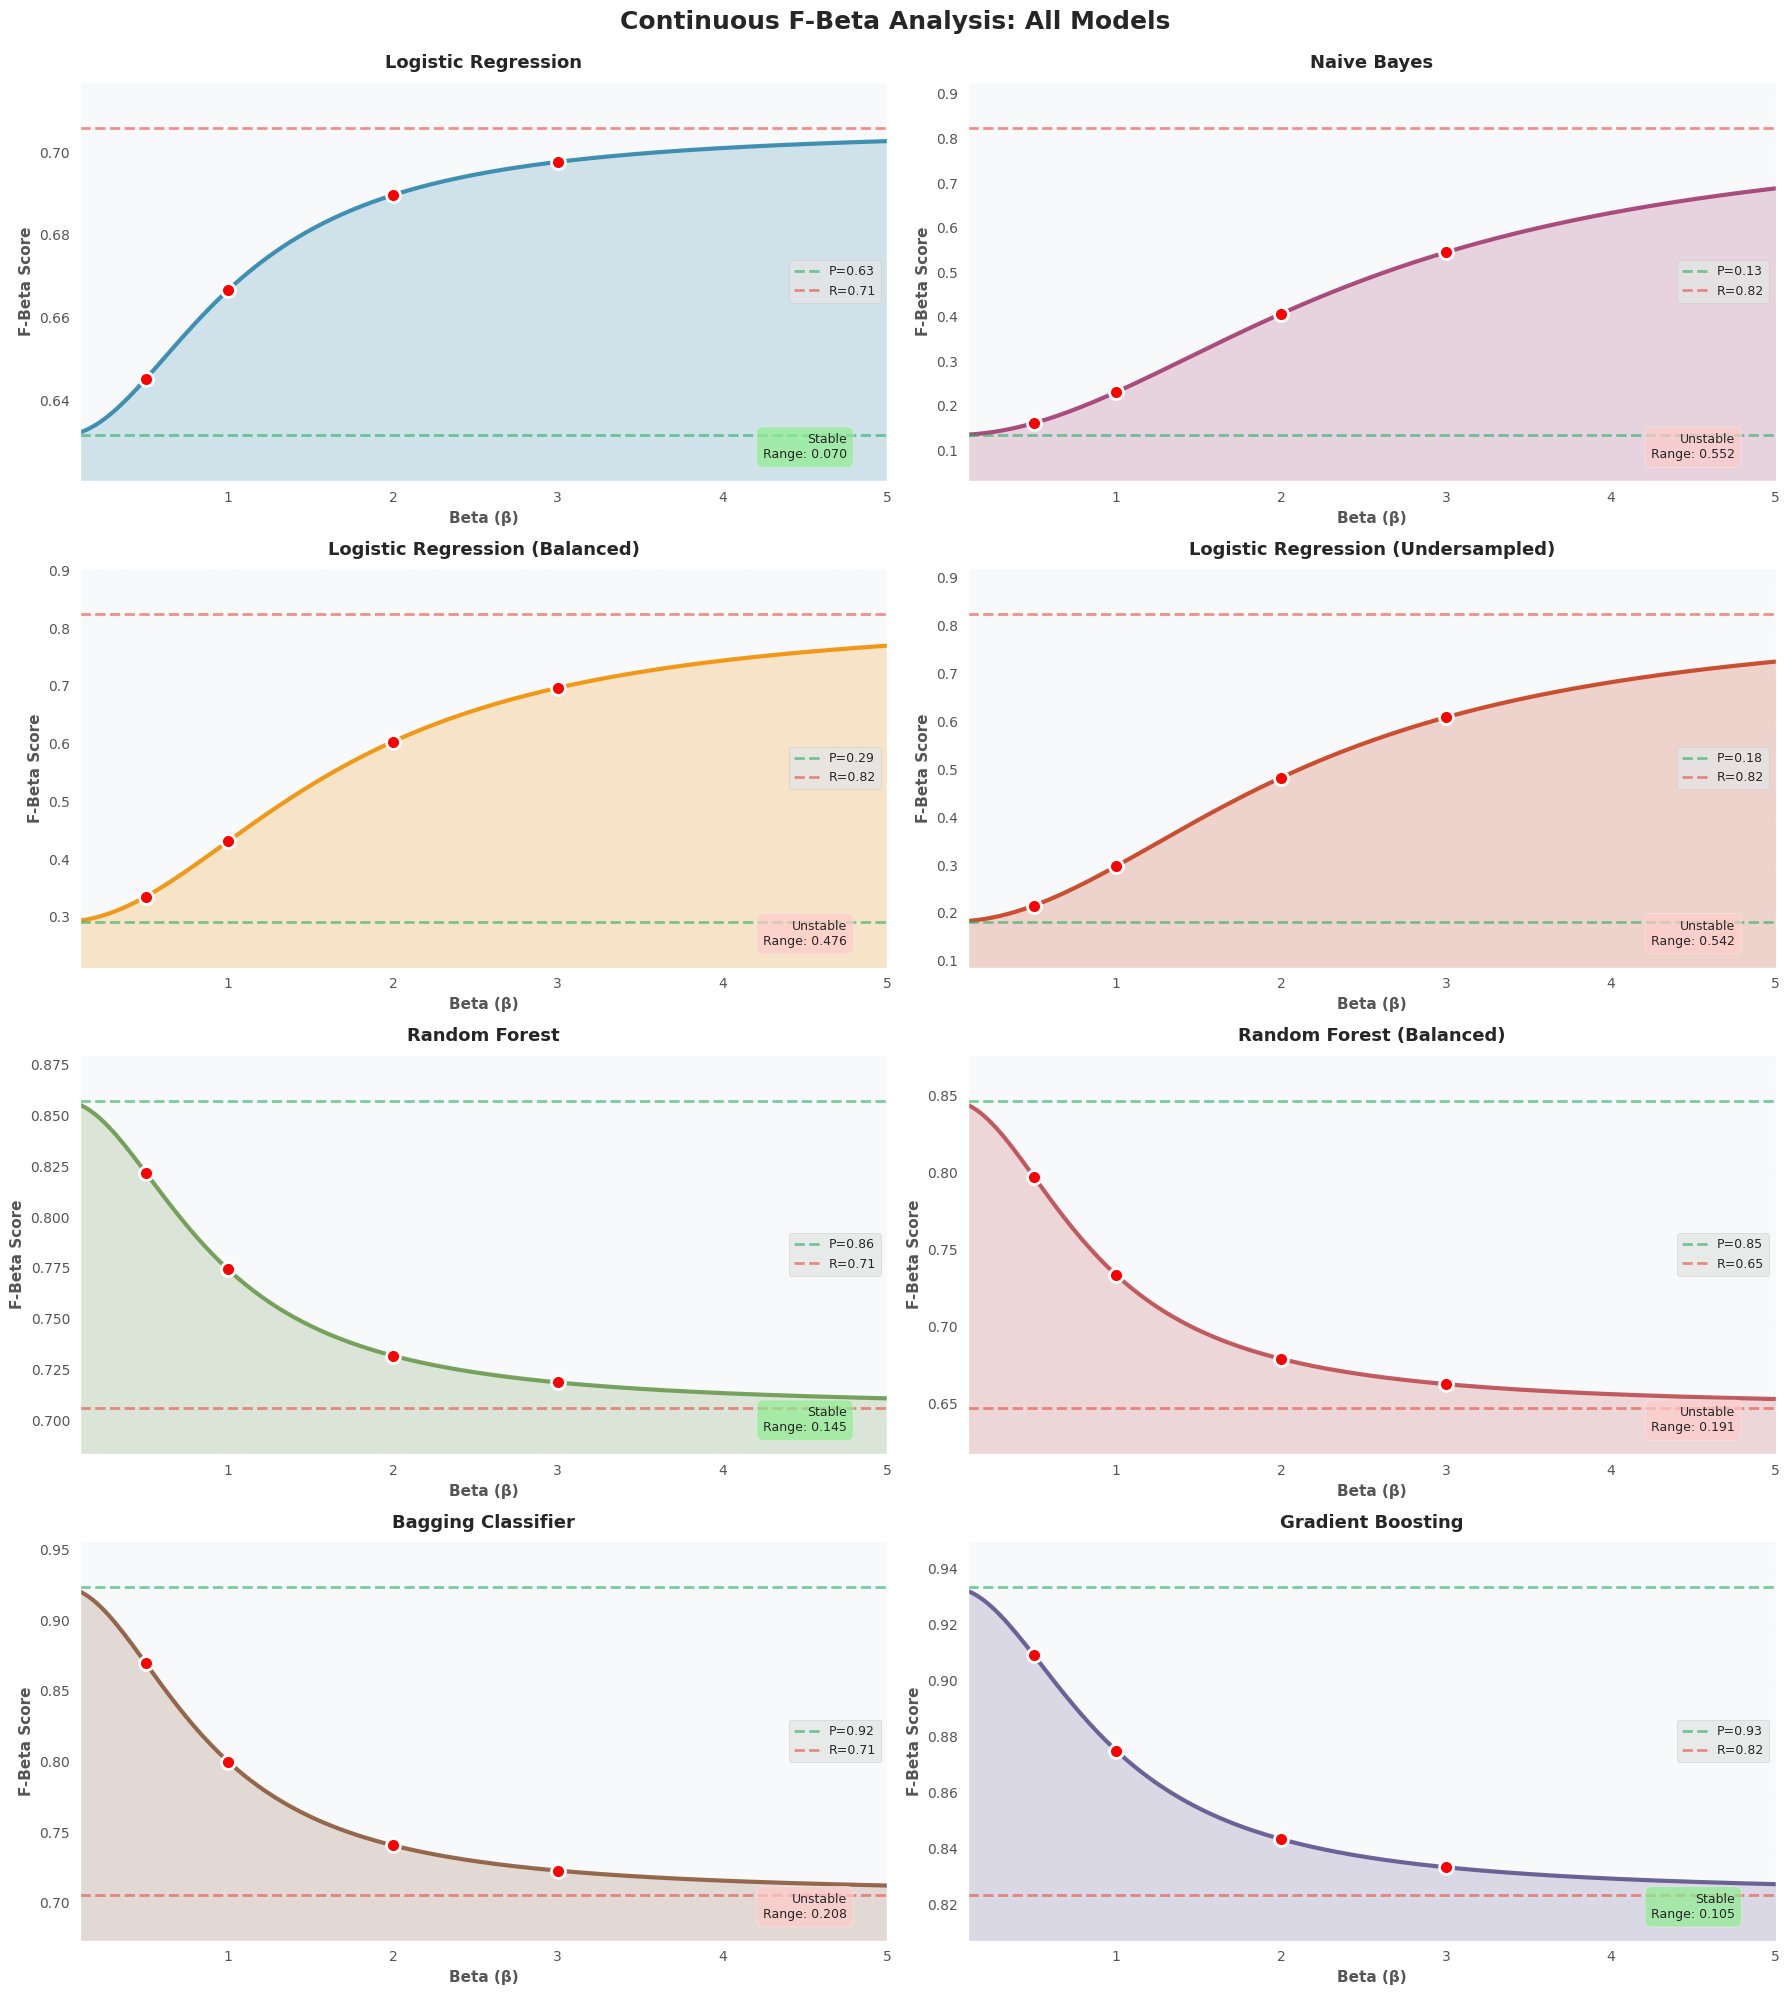

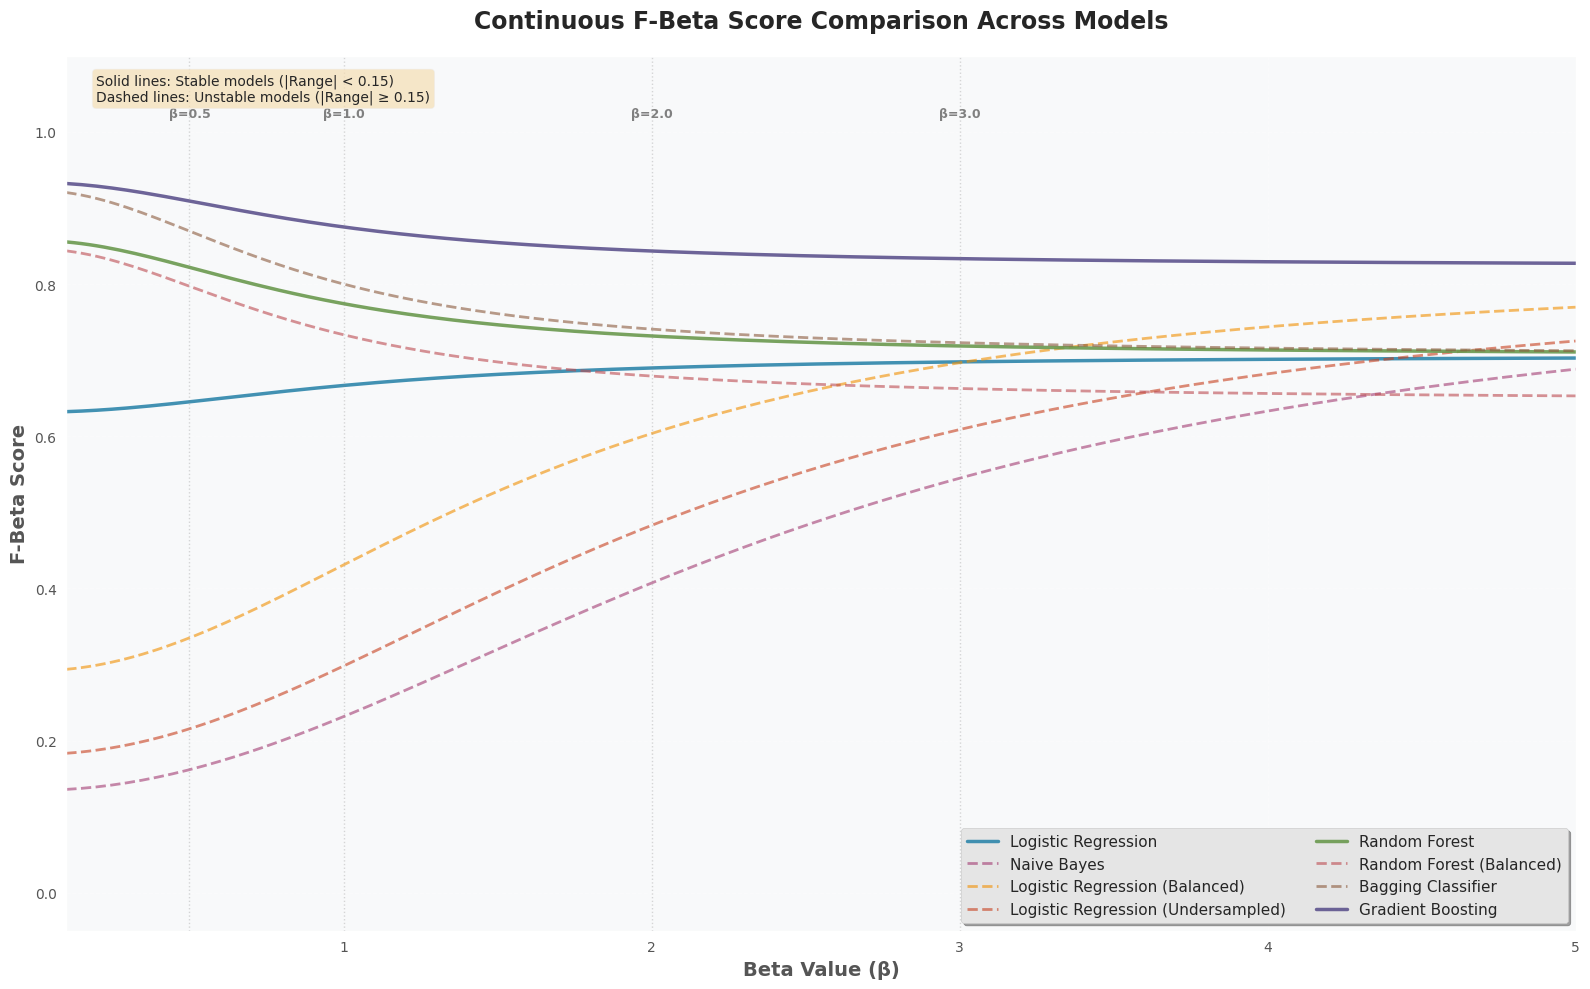

In [40]:
models_for_comparison = {}
for name, result in models.items():
    models_for_comparison[name] = {
        'y_true': y_test,
        'y_pred': result['y_pred']
    }


fig, axes = plot_continuous_fbeta_grid(
    models_dict=models_for_comparison,
    beta_range=(0.1, 5.0),
    num_points=200,
    save_fig=False,
)

fig, ax, all_results = plot_continuous_fbeta_comparison(
    models_dict=models_for_comparison,
    beta_range=(0.1, 5.0),
    num_points=200,
    save_fig=False,
)


# **5. Model Comparison**

# 5. Model Comparison

Tree-based models (Random Forest, Bagging, XGBoost) achieve the best balance between **detecting frauds** and **minimizing false positives**, reflected in high F-beta scores. They handle non-linear patterns and scattered fraud cases effectively, capturing complex interactions between features.  

Linear models (Logistic Regression and variants) and Naive Bayes struggle because they rely on **single decision surfaces**. Standard Logistic Regression is conservative, achieving moderate recall (65%) and high precision (83%), but misses many frauds. Balanced Logistic Regression increases recall (92%) but generates excessive false positives (1,385), while undersampling creates similar recall with even more false alarms.  

Naive Bayes, despite non-linear boundaries, suffers from **feature independence assumptions**, producing low precision (6%) due to numerous false positives, even though recall is relatively high (85%).  

Overall, tree-based ensemble methods are most suitable for imbalanced fraud detection, offering **high recall, strong precision, and operational flexibility**, making them production-ready.


2D Model Performance on Test Set:
Logistic Regression - Recall: 0.353, Precision: 0.353
Naive Bayes - Recall: 0.824, Precision: 0.304
XGBoost - Recall: 0.765, Precision: 0.419



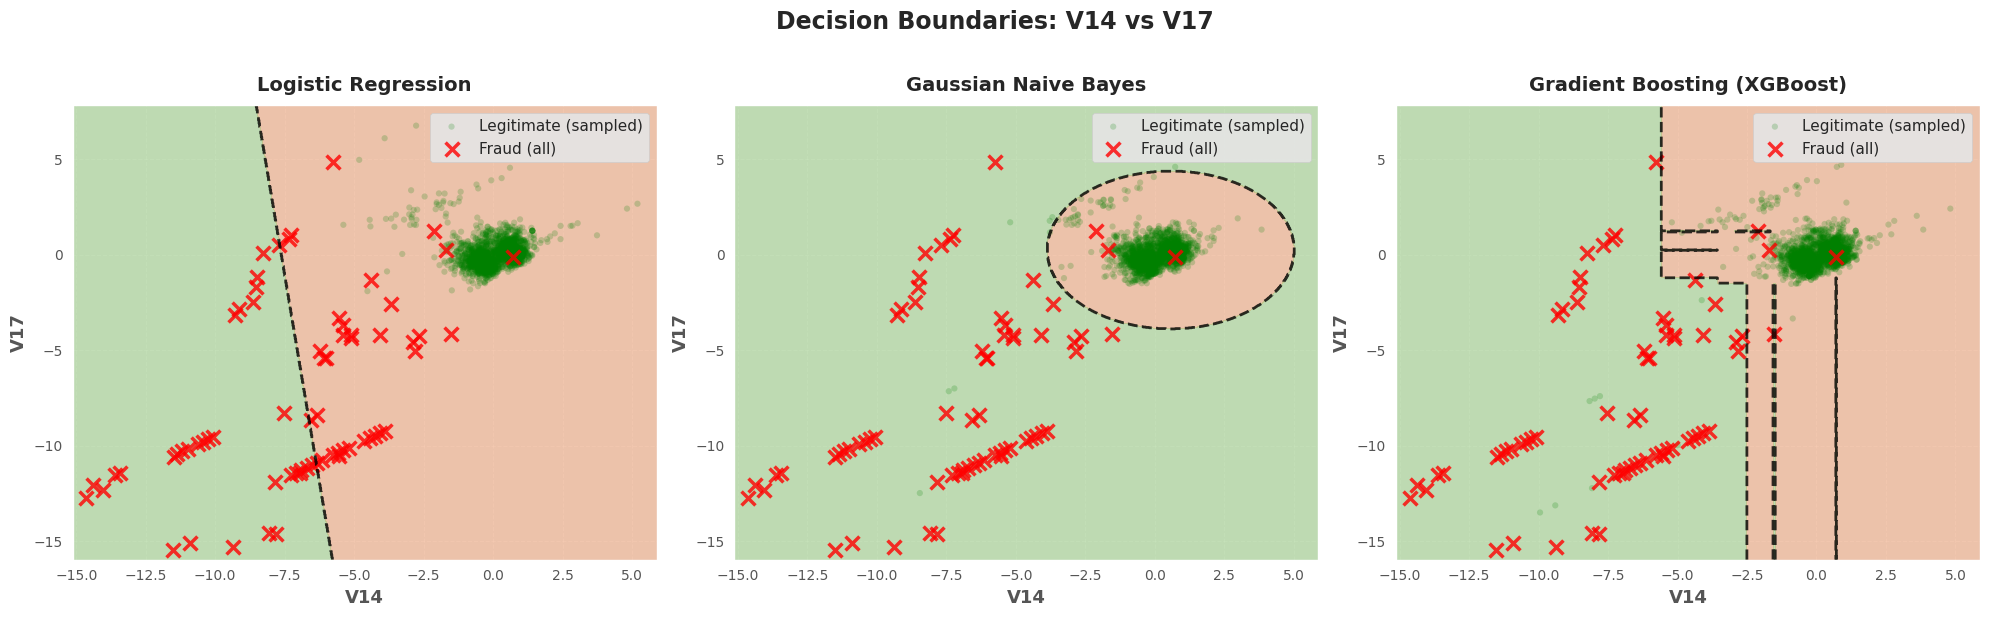

In [41]:
# Decision Boundary Visualization (2D) - Training on 2 Features Only
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Select two features for visualization
feature_indices = [14, 17]
X_2d_train = X_train_scaled.iloc[:, feature_indices].values
X_2d_test = X_test_scaled.iloc[:, feature_indices].values
feature_names = X_train.columns[feature_indices]

# Train NEW models using ONLY these 2 features
lr_2d = LogisticRegression(random_state=42, max_iter=1000)
nb_2d = GaussianNB()
xgb_2d = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    max_depth=3,  # Shallower tree for 2D visualization
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

# Fit models on 2D data
lr_2d.fit(X_2d_train, y_train)
nb_2d.fit(X_2d_train, y_train)
xgb_2d.fit(X_2d_train, y_train)

# Evaluate 2D models
print("2D Model Performance on Test Set:")
print(f"Logistic Regression - Recall: {recall_score(y_test, lr_2d.predict(X_2d_test)):.3f}, Precision: {precision_score(y_test, lr_2d.predict(X_2d_test)):.3f}")
print(f"Naive Bayes - Recall: {recall_score(y_test, nb_2d.predict(X_2d_test)):.3f}, Precision: {precision_score(y_test, nb_2d.predict(X_2d_test)):.3f}")
print(f"XGBoost - Recall: {recall_score(y_test, xgb_2d.predict(X_2d_test)):.3f}, Precision: {precision_score(y_test, xgb_2d.predict(X_2d_test)):.3f}")
print()

# Create mesh for decision boundary
x_min, x_max = X_2d_train[:, 0].min() - 0.5, X_2d_train[:, 0].max() + 0.5
y_min, y_max = X_2d_train[:, 1].min() - 0.5, X_2d_train[:, 1].max() + 0.5
h = 0.02  # mesh step size
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models = [
    (lr_2d, "Logistic Regression", 0),
    (nb_2d, "Gaussian Naive Bayes", 1),
    (xgb_2d, "Gradient Boosting (XGBoost)", 2),
]

for model, title, idx in models:
    ax = axes[idx]

    # Predict on mesh (only 2 features now!)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    contour = ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdYlGn", levels=[0, 0.5, 1])

    # Add decision boundary line
    ax.contour(xx, yy, Z, colors='black', linewidths=2, levels=[0.5], linestyles='--', alpha=0.8)

    # Plot training points
    fraud_mask = y_train == 1
    legit_mask = y_train == 0

    # Sample legitimate transactions for cleaner plot
    legit_indices = np.where(legit_mask)[0]
    sampled_legit = np.random.choice(
        legit_indices, size=min(2000, len(legit_indices)), replace=False
    )

    # Plot legitimate transactions (sampled)
    ax.scatter(
        X_2d_train[sampled_legit, 0],
        X_2d_train[sampled_legit, 1],
        c="green",
        label="Legitimate (sampled)",
        alpha=0.2,
        edgecolors="none",
        s=20,
    )

    # Plot ALL fraud transactions
    ax.scatter(
        X_2d_train[fraud_mask, 0],
        X_2d_train[fraud_mask, 1],
        c="red",
        label="Fraud (all)",
        alpha=0.8,
        edgecolors="darkred",
        s=100,
        marker="x",
        linewidths=2.5,
    )

    # Styling
    ax.set_xlabel(feature_names[0], fontsize=13, fontweight='bold')
    ax.set_ylabel(feature_names[1], fontsize=13, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight="bold", pad=10)
    ax.legend(fontsize=11, loc="best", framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

plt.suptitle(
    f"Decision Boundaries: {feature_names[0]} vs {feature_names[1]}",
    fontsize=17,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("decision_boundaries_2d_pure.png", dpi=300, bbox_inches="tight")
plt.show()